# Demand for Shared Bikes 🏇

## Importing necessary libraries

In [1]:
import os

import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

### Setting display options for better visibility of data

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 800)
pd.set_option('display.float_format', '{:.2f}'.format)

### Consents

In [3]:
# After learning data dictionary
SEASON_MAPPINGS = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
YEAR_MAPPINGS = {0: 2018, 1: 2019}
MONTH_MAPPINGS = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                  7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
WEEKDAY_MAPPINGS = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                    4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
HOLIDAY_DAY_MAPPINGS = {1: True, 0: False}
WORKING_DAY_MAPPINGS = {1: True, 0: False}
WEATHER_SIT_MAPPINGS = {1: 'Clear or Few Clouds', 2: 'Mist + Cloudy', 
                        3: 'Light Snow or Rain', 4: 'Heavy Snow or Rain'}

## 🥤Methods

### Data Visualization methods

In [4]:
def visualize_lineplot_minimal(df: pd.DataFrame, datetime_col: str, count_col: str, is_subplot = False) -> None:
    """
    Visualizes the time series distribution of a datetime column with minimal colors and value labels.
    """

    # Ensure datetime format and handle potential errors
    try:
        df[datetime_col] = pd.to_datetime(df[datetime_col])
    except (ValueError, TypeError):
        print(f"Error: Invalid format for datetime column '{datetime_col}'. Ensure valid datetime format.")
        return

    # Create a line plot with minimal colors and clear formatting
    if not is_subplot:
        plt.figure(figsize=(20, 6))
    sns.lineplot( x=datetime_col, y=count_col, data=df, marker='o', linewidth=2, legend=False)
    
    # Customize plot elements for readability and clarity
    plt.title(f"Distribution of {datetime_col.replace('_', ' ').capitalize()}")
    plt.xlabel(f"{datetime_col.replace('_', ' ').capitalize()}")
    plt.grid(True, linestyle='--', alpha=0.6)  
    plt.xticks(rotation=90)
    plt.ylabel(count_col)
    plt.tight_layout()
    if not is_subplot:
        plt.show()

def visualize_boxplot_minimal(df: pd.DataFrame, col: str, is_subplot = False) -> None:
    """
    Creates a minimal seaborn boxplot for a given column in a pandas DataFrame.
    """

    if not is_subplot:
        # Set figure size for better readability
        plt.figure(figsize=(8, 5))

    # Create the boxplot with improved aesthetics
    sns.boxplot( x=col, data=df, color="skyblue", medianprops={"linewidth": 2} )

    # Customize title and labels for clarity
    plt.title(f"Box Plot of {col.replace('_', ' ').capitalize()}", fontsize=14)
    plt.xlabel(f"{col.replace('_', ' ').capitalize()}", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7) 
    plt.tight_layout() 
    if not is_subplot:
        plt.show()

def visualize_countplot_minimal(df: pd.DataFrame, categorical_col: str, is_subplot = False) -> None:
    """
        Visualizes the distribution of a categorical column with minimal colors and value labels.
    """
    # Ensure order is a list of category labels
    order = sorted(df[categorical_col].unique())
    rotation = 0
    if len(order) > 5:
        rotation = 90
    # Visualize the distribution using a bar plot with minimal colors
    if not is_subplot:
        plt.figure(figsize=(10, 6))
    counts = df[categorical_col].value_counts().sort_index() 
    sns.countplot( x=categorical_col, data=df, hue=categorical_col, palette="Set2", order= order, legend=False)

    for i, (_, count) in enumerate(counts.items()):
        plt.text(i, count + 0.1, f"{round(count*100/counts.sum(), 2)}%", ha='center', va='bottom', fontsize=12, rotation=rotation)
    
    plt.title(f"Distribution of {categorical_col.replace('_', ' ').capitalize()}")
    plt.xlabel(categorical_col.replace('_', ' ').capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if not is_subplot:
        plt.show()
    
def visualize_histplot_minimal(df: pd.DataFrame, num_col: str, kde = True, bin = 30, is_subplot = False) -> None:
    """
        Visualizes the distribution of a numerical column with minimal colors and value labels.
    """
    # Visualize distributions (Example: Loan amount)
    if not is_subplot:
        plt.figure(figsize=(10, 6))
    sns.histplot(df[num_col], kde = kde, bins = bin, color='blue')
    plt.title(f"{num_col.replace('_',  ' ').capitalize()} Distribution")
    plt.xlabel(num_col.replace('_',  ' ').capitalize())
    plt.ylabel('Frequency')
    if not is_subplot:
        plt.show()

def visualize_numerical_vs_categorical(df, numerical_col, categorical_col, is_subplot = False):
    """
    Visualizes the distribution of a numerical variable across different categories of a categorical variable.
    """
    if not is_subplot:
        plt.figure(figsize=(10, 8))

    # Create a violin plot
    sns.violinplot(x=categorical_col, y=numerical_col, data=df, split=True)
    plt.title(f"Distribution of {numerical_col.replace('_', ' ').capitalize()} by {categorical_col.replace('_', ' ').capitalize()}")
    plt.xlabel(categorical_col.replace('_', ' ').capitalize())
    plt.ylabel(numerical_col.replace('_', ' ').capitalize())
    if not is_subplot:
        plt.show()

def visualize_categorical_vs_categorical(df, cat_col, target_col, is_subplot = False):
    grouped_df = df.groupby([cat_col, target_col]).size().reset_index(name='count')
    total_counts = df.groupby(cat_col).size().reset_index(name='total_count')
    grouped_df = grouped_df.merge(total_counts, on=cat_col)
    grouped_df['percentage'] = (grouped_df['count'] / grouped_df['total_count']) * 100

    rotation = 0
    if len(total_counts) > 5:
        rotation = 90
    # Create the bar plot
    if not is_subplot:
        plt.figure(figsize=(20, 8))
    sns.barplot(x=cat_col, y='percentage', hue=target_col, data=grouped_df, hue_order=sorted(df[target_col].unique(), reverse=True))

    # Add percentage labels to the bars
    for p in plt.gca().patches:
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2
        if height == 0: continue
        plt.annotate(f'{height:.1f}%', (x, height), ha='center', va='bottom', rotation=rotation)

    plt.xlabel(cat_col.replace('_', ' ').capitalize())
    plt.ylabel('Percentage')
    plt.title(f'Loan Status by {cat_col.replace("_", " ").capitalize()}')
    plt.xticks(rotation=rotation)
    if not is_subplot:
        plt.show()
    
def visualize_numerical_vs_numerical(df: pd.DataFrame, target_col: str, numerical_col: str, is_subplot = False):
    if not is_subplot:
        plt.figure(figsize=(12, 8))
    
    # Create the scatter plot with minimal visuals
    sns.scatterplot(x=numerical_col, y=target_col, data=df, color="0.3") 
    
    plt.title(f"Distribution of {numerical_col.replace('_', ' ').capitalize()} by {target_col.replace('_', ' ').capitalize()}")
    plt.xlabel(numerical_col.replace('_', ' ').capitalize())
    plt.ylabel(target_col.replace('_', ' ').capitalize())
    if not is_subplot:
        plt.show()
        
def visualize_numerical_vs_numerical_on_categorical_hue(df: pd.DataFrame, numerical_col: str, target_col: str, hue_col: str, is_subplot = False):
    if not is_subplot:
        plt.figure(figsize=(12, 8))

    # Create the scatter plot with minimal visuals
    sns.scatterplot(x=numerical_col, y=target_col, data=df, hue=hue_col, color="0.3") 

    plt.title(f"Distribution of {numerical_col.replace('_', ' ').capitalize()} by {target_col.replace('_', ' ').capitalize()}")
    plt.xlabel(numerical_col.replace('_', ' ').capitalize())
    plt.ylabel(target_col.replace('_', ' ').capitalize())
    if not is_subplot:
        plt.show()

### Data Processing Methods

In [5]:
def remap_categorical_to_numeric(df: pd.DataFrame, column_name: str, mapping: dict[int, str]):
    """
        Remaps a categorical column in a DataFrame to numerical values based on a provided mapping dictionary.
    """
    # Create a reverse mapping dictionary for efficient lookup
    rev_mapping = {value: key for key, value in mapping.items()} 
    return df[column_name].map(rev_mapping)



### Calculation methods:

In [6]:
def get_outlier_count(df: pd.DataFrame, col_name: str) -> None:
    """Calculates and prints the number of outliers in a specified column using the IQR method.
    """
    # IQR method example
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Outliers in {col_name}:", df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)].shape[0])

## ⚙Loading datasets

In [7]:
# Replace 'bike_data_path' with the actual path to the files
current_dir = %pwd # type: ignore
data_dir = os.path.join(current_dir, '..', 'data')
bike_data_path = os.path.join(data_dir, 'raw', 'day.csv')

In [8]:
# Loading bike data
try:
    bike_df_raw: pd.DataFrame = pd.read_csv(bike_data_path, low_memory = False, sep = ',')
    print(f"Loan data loaded successfully. Shape: {bike_df_raw.shape}")
except FileNotFoundError:
    print("Error: loan.csv file not found. Please check the file path.")

Loan data loaded successfully. Shape: (730, 16)


In [9]:
# Displaying first few rows of the dataset
print("\nFirst 10 rows of the bike data:")
display(bike_df_raw.head(10))

# Displaying first few rows of the dataset
print("\nLast 10 rows of the bike data:")
display(bike_df_raw.tail(10))


First 10 rows of the bike data:


instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   
5        6  06-01-2018       1   0     1        0        4           1   
6        7  07-01-2018       1   0     1        0        5           1   
7        8  08-01-2018       1   0     1        0        6           0   
8        9  09-01-2018       1   0     1        0        0           0   
9       10  10-01-2018       1   0     1        0        1           1   

   weathersit  temp  atemp   hum  windspeed  casual  registered   cnt  
0           2 14.11  18.18 80.58      10.75     331         654   985  
1           2 14.90  17.69 69.61      16.65     131         670   801  
2           1  8.05   9.47 43.73      16.64     120        1229  1349  
3           1  8.20  10.61 59.04      10.74     108        1454  1562  
4           1  9.31  11.46 43.70      12.52      82        1518  1600  
5           1  8.38  11.66 51.83       6.00      88        1518  1606  
6           2  8.06  10.44 49.87      11.30     148        1362  1510  
7           2  6.76   8.11 53.58      17.88      68         891   959  
8           1  5.67   5.81 43.42      24.25      54         768   822  
9           1  6.18   7.54 48.29      14.96      41        1280  1321


Last 10 rows of the bike data:


instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
720      721  22-12-2019       1   1    12        0        6           0   
721      722  23-12-2019       1   1    12        0        0           0   
722      723  24-12-2019       1   1    12        0        1           1   
723      724  25-12-2019       1   1    12        1        2           0   
724      725  26-12-2019       1   1    12        0        3           1   
725      726  27-12-2019       1   1    12        0        4           1   
726      727  28-12-2019       1   1    12        0        5           1   
727      728  29-12-2019       1   1    12        0        6           0   
728      729  30-12-2019       1   1    12        0        0           0   
729      730  31-12-2019       1   1    12        0        1           1   

     weathersit  temp  atemp   hum  windspeed  casual  registered   cnt  
720           1 10.90  11.81 44.12      27.29     205        1544  1749  
721           1 10.08  12.97 51.54       8.92     408        1379  1787  
722           2  9.48  12.95 79.13       5.17     174         746   920  
723           2 11.94  14.72 73.48      11.30     440         573  1013  
724           3  9.98  11.02 82.33      21.21       9         432   441  
725           2 10.42  11.33 65.29      23.46     247        1867  2114  
726           2 10.39  12.75 59.00      10.42     644        2451  3095  
727           2 10.39  12.12 75.29       8.33     159        1182  1341  
728           1 10.49  11.59 48.33      23.50     364        1432  1796  
729           2  8.85  11.17 57.75      10.37     439        2290  2729

In [10]:
# Displaying column information
print("\nDataset Information:")
bike_df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [11]:
# Displaying descriptive statistics for numeric columns
print("\nDescriptive Statistics for Numeric Columns:")
display(bike_df_raw.describe())


Descriptive Statistics for Numeric Columns:


instant  season     yr   mnth  holiday  weekday  workingday  \
count   730.00  730.00 730.00 730.00   730.00   730.00      730.00   
mean    365.50    2.50   0.50   6.53     0.03     3.00        0.68   
std     210.88    1.11   0.50   3.45     0.17     2.01        0.47   
min       1.00    1.00   0.00   1.00     0.00     0.00        0.00   
25%     183.25    2.00   0.00   4.00     0.00     1.00        0.00   
50%     365.50    3.00   0.50   7.00     0.00     3.00        1.00   
75%     547.75    3.00   1.00  10.00     0.00     5.00        1.00   
max     730.00    4.00   1.00  12.00     1.00     6.00        1.00   

       weathersit   temp  atemp    hum  windspeed  casual  registered     cnt  
count      730.00 730.00 730.00 730.00     730.00  730.00      730.00  730.00  
mean         1.39  20.32  23.73  62.77      12.76  849.25     3658.76 4508.01  
std          0.54   7.51   8.15  14.24       5.20  686.48     1559.76 1936.01  
min          1.00   2.42   3.95   0.00       1.50    2.00       20.00   22.00  
25%          1.00  13.81  16.89  52.00       9.04  316.25     2502.25 3169.75  
50%          1.00  20.47  24.37  62.62      12.13  717.00     3664.50 4548.50  
75%          2.00  26.88  30.45  72.99      15.63 1096.50     4783.25 5966.00  
max          3.00  35.33  42.04  97.25      34.00 3410.00     6946.00 8714.00

In [12]:
bike_df_raw['weathersit'].value_counts()

weathersit
1    463
2    246
3     21
Name: count, dtype: int64

In [13]:
# Checking for missing values
print("\nMissing Values in Each Column:")
missing_values = bike_df_raw.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])  # Display only columns with missing values


Missing Values in Each Column:
Series([], dtype: int64)


In [14]:
# Checking for duplicate rows
duplicates = bike_df_raw.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


### 📈 Data Understanding

**Dataset Overview:**

day.csv dataset is provided by BoomBikes (US bike-sharing Company), records of 2 years (730 days) explains daily bike demands across the American market. It consists of 15 columns, primarily numeric (11 int64, 4 float64) with a smaller portion of categorical data (1 object).

**Data Understanding and Observations:**
1. Unique Identifiers: 💡
   - `instant`, this column is unique identifier.
2. Date and season: 📅
   - `dteday`, is date column ranges from (01-Jan-2018 to 31-Dec-2019).
   - `season`, is season (1:spring, 2:summer, 3:fall, 4:winter).
3. Date explained: (year, month, weekday, holiday, working day)
   - `yr`, is year (0: 2018, 1:2019).
   - `mnth`, is month ( 1 to 12).
   - `weekday`, is day of the week (0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                    4: 'Friday', 5: 'Saturday', 6: 'Sunday').
   - `holiday`, is weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule).
   - `workingday`, if day is neither weekend nor holiday is 1, otherwise is 0.
4. Environment explained: (temperature, feeling temperature, humidity, wind speed, weather sit)
   - `temp`, is temperature in Celsius. Average temperature is 20.32 Celsius and Max temperature is 35.33 Celsius.
   - `atemp`, is feeling temperature in Celsius. Average temperature is 23.73 Celsius and Max temperature is 42.04 Celsius.
   - `hum`, is humidity. Average humidity is 62.77 and Max humidity is 97.25.
   - `windspeed`, is wind speed in Meter per Second. Average speed is 12.76 and Max speed is 34.
   - `weathersit` is weather status (1: 'Clear or Few Clouds', 2: 'Mist + Cloudy', 
                        3: 'Light Snow or Rain', 4: 'Heavy Snow or Rain').
5. Prediction features: (casual, registered, count = casual + registered)
   - `casual`, is count of casual users demand. Average is ~849 users and Max 3410 users.
   - `registered`, is count of registered users demand. Average is ~3659 users and Max 6946 users.
   - `cnt`, is count of total rental bikes including both casual and registered users demand. Average ~4508 users and Max 8714 users.

**Missing / Duplicate Data:**
- No missing / Duplicate data found

**Data observations / Quality Concerns:**
- `weekday` column, `01-Jan-2018` is `Monday` but marked as `Sunday`.
- `workingday` column, as `weekday` column has errors this need to be revisited. If you observer average working days is 0.68 seems unusually high and may indicate an issue with data.
- `instant` column, as it's index column this will not contribute to prediction features we may can drop in upcoming data processing.

## 🧹 Data Cleaning and Manipulation

### 🔃Data processing

In [15]:
# Drop unnecessary columns

# Let's get rid of those columns that don't tell us anything interesting 🗑️.
columns_to_drop = ['instant'] # dropping identifier/index as they are not relevant for analysis 
bike_clean_df = bike_df_raw.drop(columns=columns_to_drop)

# Convert relevant column to datetime format
bike_clean_df['date'] = pd.to_datetime(bike_clean_df['dteday'], dayfirst=True)

# Mapping values based on the provided data dictionary
bike_clean_df['season'] = bike_clean_df['season'].map(SEASON_MAPPINGS)
bike_clean_df['year'] = bike_clean_df['yr'].map(YEAR_MAPPINGS)
bike_clean_df['month'] = bike_clean_df['mnth'].map(MONTH_MAPPINGS)
bike_clean_df['holiday'] = bike_clean_df['holiday'].map(HOLIDAY_DAY_MAPPINGS)
bike_clean_df['weekday'] = bike_clean_df['weekday'].map(WEEKDAY_MAPPINGS)
bike_clean_df['workingday'] = bike_clean_df['workingday'].map(WORKING_DAY_MAPPINGS)
bike_clean_df['weathersit'] = bike_clean_df['weathersit'].map(WEATHER_SIT_MAPPINGS)

# Selecting renamed columns with order
bike_clean_df = bike_clean_df[['date', 'season', 'year', 'month', 'weekday', 'holiday', 'workingday', 
               'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']]

# Displaying column information
print("\nDataset Information:")
bike_clean_df.info()

# Displaying first few rows of the dataset
print("\nFirst 15 rows of the bike data:")
display(bike_clean_df.head(15))

# Displaying first few rows of the dataset
print("\nLast 15 rows of the bike data:")
display(bike_clean_df.tail(15))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        730 non-null    datetime64[ns]
 1   season      730 non-null    object        
 2   year        730 non-null    int64         
 3   month       730 non-null    object        
 4   weekday     730 non-null    object        
 5   holiday     730 non-null    bool          
 6   workingday  730 non-null    bool          
 7   weathersit  730 non-null    object        
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  casual      730 non-null    int64         
 13  registered  730 non-null    int64         
 14  cnt         730 non-null    int64         
dtypes: bool(2), datetime64[ns](1), float64(4), int64(4),

date  season  year    month    weekday  holiday  workingday  \
0  2018-01-01  Spring  2018  January     Sunday    False       False   
1  2018-01-02  Spring  2018  January     Monday    False       False   
2  2018-01-03  Spring  2018  January    Tuesday    False        True   
3  2018-01-04  Spring  2018  January  Wednesday    False        True   
4  2018-01-05  Spring  2018  January   Thursday    False        True   
5  2018-01-06  Spring  2018  January     Friday    False        True   
6  2018-01-07  Spring  2018  January   Saturday    False        True   
7  2018-01-08  Spring  2018  January     Sunday    False       False   
8  2018-01-09  Spring  2018  January     Monday    False       False   
9  2018-01-10  Spring  2018  January    Tuesday    False        True   
10 2018-01-11  Spring  2018  January  Wednesday    False        True   
11 2018-01-12  Spring  2018  January   Thursday    False        True   
12 2018-01-13  Spring  2018  January     Friday    False        True   
13 2018-01-14  Spring  2018  January   Saturday    False        True   
14 2018-01-15  Spring  2018  January     Sunday    False       False   

             weathersit  temp  atemp   hum  windspeed  casual  registered  \
0         Mist + Cloudy 14.11  18.18 80.58      10.75     331         654   
1         Mist + Cloudy 14.90  17.69 69.61      16.65     131         670   
2   Clear or Few Clouds  8.05   9.47 43.73      16.64     120        1229   
3   Clear or Few Clouds  8.20  10.61 59.04      10.74     108        1454   
4   Clear or Few Clouds  9.31  11.46 43.70      12.52      82        1518   
5   Clear or Few Clouds  8.38  11.66 51.83       6.00      88        1518   
6         Mist + Cloudy  8.06  10.44 49.87      11.30     148        1362   
7         Mist + Cloudy  6.76   8.11 53.58      17.88      68         891   
8   Clear or Few Clouds  5.67   5.81 43.42      24.25      54         768   
9   Clear or Few Clouds  6.18   7.54 48.29      14.96      41        1280   
10        Mist + Cloudy  6.93   9.57 68.64       8.18      43        1220   
11  Clear or Few Clouds  7.08   8.02 59.95      20.41      25        1137   
12  Clear or Few Clouds  6.76   7.54 47.04      20.17      38        1368   
13  Clear or Few Clouds  6.60   9.42 53.78       8.48      54        1367   
14        Mist + Cloudy  9.57  12.41 49.88      10.58     222        1026   

     cnt  
0    985  
1    801  
2   1349  
3   1562  
4   1600  
5   1606  
6   1510  
7    959  
8    822  
9   1321  
10  1263  
11  1162  
12  1406  
13  1421  
14  1248


Last 15 rows of the bike data:


date  season  year     month    weekday  holiday  workingday  \
715 2019-12-17  Winter  2019  December    Tuesday    False        True   
716 2019-12-18  Winter  2019  December  Wednesday    False        True   
717 2019-12-19  Winter  2019  December   Thursday    False        True   
718 2019-12-20  Winter  2019  December     Friday    False        True   
719 2019-12-21  Spring  2019  December   Saturday    False        True   
720 2019-12-22  Spring  2019  December     Sunday    False       False   
721 2019-12-23  Spring  2019  December     Monday    False       False   
722 2019-12-24  Spring  2019  December    Tuesday    False        True   
723 2019-12-25  Spring  2019  December  Wednesday     True       False   
724 2019-12-26  Spring  2019  December   Thursday    False        True   
725 2019-12-27  Spring  2019  December     Friday    False        True   
726 2019-12-28  Spring  2019  December   Saturday    False        True   
727 2019-12-29  Spring  2019  December     Sunday    False       False   
728 2019-12-30  Spring  2019  December     Monday    False       False   
729 2019-12-31  Spring  2019  December    Tuesday    False        True   

              weathersit  temp  atemp   hum  windspeed  casual  registered  \
715        Mist + Cloudy 16.13  20.07 90.71       6.58     212        4373   
716  Clear or Few Clouds 16.84  20.49 66.62      14.83     433        5124   
717  Clear or Few Clouds 13.63  17.11 62.54      12.33     333        4934   
718        Mist + Cloudy 13.53  16.76 66.79       8.88     314        3814   
719        Mist + Cloudy 13.39  15.09 55.67      25.08     221        3402   
720  Clear or Few Clouds 10.90  11.81 44.12      27.29     205        1544   
721  Clear or Few Clouds 10.08  12.97 51.54       8.92     408        1379   
722        Mist + Cloudy  9.48  12.95 79.13       5.17     174         746   
723        Mist + Cloudy 11.94  14.72 73.48      11.30     440         573   
724   Light Snow or Rain  9.98  11.02 82.33      21.21       9         432   
725        Mist + Cloudy 10.42  11.33 65.29      23.46     247        1867   
726        Mist + Cloudy 10.39  12.75 59.00      10.42     644        2451   
727        Mist + Cloudy 10.39  12.12 75.29       8.33     159        1182   
728  Clear or Few Clouds 10.49  11.59 48.33      23.50     364        1432   
729        Mist + Cloudy  8.85  11.17 57.75      10.37     439        2290   

      cnt  
715  4585  
716  5557  
717  5267  
718  4128  
719  3623  
720  1749  
721  1787  
722   920  
723  1013  
724   441  
725  2114  
726  3095  
727  1341  
728  1796  
729  2729

#### 👀Observations:
- `weekday` column appears to be inconsistent as 01-January-2018 is Monday
- After reviewing following articles of 2018 and 2019 holiday lists Data in `holiday` column appears inconsistent.
  - https://web.archive.org/web/20180306140856/https://dchr.dc.gov/page/holiday-schedules
  - https://web.archive.org/web/20190110035645/https://dchr.dc.gov/page/holiday-schedules  
- After reviewing (wiki workweek and weekend)[https://en.wikipedia.org/wiki/Workweek_and_weekend] article, weekends are considered Saturday and Sunday but `workingday` column appears inconsistent, not following the rule provided in data dictionary.

#### 📌Next Steps:
- Redefine `weekday` column using datetime python module
- Redefine `holiday` column with list
- Redefine `workingday` column as per data dictionary definition.

In [16]:
# Holiday list after reviewing holiday schedules artical by dchr.dc.gov for 2018 and 2019
# HOLIDAY_DATES = ['2018-01-01', '2018-01-15', '2018-02-22', '2018-04-16', '2018-05-28', 
#                  '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12', '2018-11-22', '2018-12-25', 
#                  '2019-01-01', '2019-01-21', '2019-02-18', '2019-04-16', '2019-05-27', 
#                  '2019-07-04', '2019-09-02', '2019-10-14', '2019-11-11', '2019-11-28', '2019-12-25']

# Creating copy for future referance
bike_df = bike_clean_df.copy(deep = True)

# Correcting the values as per definition
bike_df['weekday'] = bike_df['date'].dt.weekday.map(WEEKDAY_MAPPINGS)

bike_df['year'] = bike_df['date'].dt.year.astype(str)
bike_df['month'] = bike_df['date'].dt.month.map(MONTH_MAPPINGS)

categorical_cols = ['season', 'year', 'month', 'weekday', 'holiday', 'workingday', 'weathersit']
bike_df[categorical_cols] = bike_df[categorical_cols].apply(lambda x: x.astype('category'))

# Displaying column information
print("\nDataset Information:")
bike_df.info()

# Displaying first few rows of the dataset
print("\nFirst 15 rows of the bike data:")
display(bike_df.head(15))

# Displaying first few rows of the dataset
print("\nLast 15 rows of the bike data:")
display(bike_df.tail(15))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        730 non-null    datetime64[ns]
 1   season      730 non-null    category      
 2   year        730 non-null    category      
 3   month       730 non-null    category      
 4   weekday     730 non-null    category      
 5   holiday     730 non-null    category      
 6   workingday  730 non-null    category      
 7   weathersit  730 non-null    category      
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  casual      730 non-null    int64         
 13  registered  730 non-null    int64         
 14  cnt         730 non-null    int64         
dtypes: category(7), datetime64[ns](1), float64(4), int64

date  season  year    month    weekday holiday workingday  \
0  2018-01-01  Spring  2018  January     Monday   False      False   
1  2018-01-02  Spring  2018  January    Tuesday   False      False   
2  2018-01-03  Spring  2018  January  Wednesday   False       True   
3  2018-01-04  Spring  2018  January   Thursday   False       True   
4  2018-01-05  Spring  2018  January     Friday   False       True   
5  2018-01-06  Spring  2018  January   Saturday   False       True   
6  2018-01-07  Spring  2018  January     Sunday   False       True   
7  2018-01-08  Spring  2018  January     Monday   False      False   
8  2018-01-09  Spring  2018  January    Tuesday   False      False   
9  2018-01-10  Spring  2018  January  Wednesday   False       True   
10 2018-01-11  Spring  2018  January   Thursday   False       True   
11 2018-01-12  Spring  2018  January     Friday   False       True   
12 2018-01-13  Spring  2018  January   Saturday   False       True   
13 2018-01-14  Spring  2018  January     Sunday   False       True   
14 2018-01-15  Spring  2018  January     Monday   False      False   

             weathersit  temp  atemp   hum  windspeed  casual  registered  \
0         Mist + Cloudy 14.11  18.18 80.58      10.75     331         654   
1         Mist + Cloudy 14.90  17.69 69.61      16.65     131         670   
2   Clear or Few Clouds  8.05   9.47 43.73      16.64     120        1229   
3   Clear or Few Clouds  8.20  10.61 59.04      10.74     108        1454   
4   Clear or Few Clouds  9.31  11.46 43.70      12.52      82        1518   
5   Clear or Few Clouds  8.38  11.66 51.83       6.00      88        1518   
6         Mist + Cloudy  8.06  10.44 49.87      11.30     148        1362   
7         Mist + Cloudy  6.76   8.11 53.58      17.88      68         891   
8   Clear or Few Clouds  5.67   5.81 43.42      24.25      54         768   
9   Clear or Few Clouds  6.18   7.54 48.29      14.96      41        1280   
10        Mist + Cloudy  6.93   9.57 68.64       8.18      43        1220   
11  Clear or Few Clouds  7.08   8.02 59.95      20.41      25        1137   
12  Clear or Few Clouds  6.76   7.54 47.04      20.17      38        1368   
13  Clear or Few Clouds  6.60   9.42 53.78       8.48      54        1367   
14        Mist + Cloudy  9.57  12.41 49.88      10.58     222        1026   

     cnt  
0    985  
1    801  
2   1349  
3   1562  
4   1600  
5   1606  
6   1510  
7    959  
8    822  
9   1321  
10  1263  
11  1162  
12  1406  
13  1421  
14  1248


Last 15 rows of the bike data:


date  season  year     month    weekday holiday workingday  \
715 2019-12-17  Winter  2019  December    Tuesday   False       True   
716 2019-12-18  Winter  2019  December  Wednesday   False       True   
717 2019-12-19  Winter  2019  December   Thursday   False       True   
718 2019-12-20  Winter  2019  December     Friday   False       True   
719 2019-12-21  Spring  2019  December   Saturday   False       True   
720 2019-12-22  Spring  2019  December     Sunday   False      False   
721 2019-12-23  Spring  2019  December     Monday   False      False   
722 2019-12-24  Spring  2019  December    Tuesday   False       True   
723 2019-12-25  Spring  2019  December  Wednesday    True      False   
724 2019-12-26  Spring  2019  December   Thursday   False       True   
725 2019-12-27  Spring  2019  December     Friday   False       True   
726 2019-12-28  Spring  2019  December   Saturday   False       True   
727 2019-12-29  Spring  2019  December     Sunday   False      False   
728 2019-12-30  Spring  2019  December     Monday   False      False   
729 2019-12-31  Spring  2019  December    Tuesday   False       True   

              weathersit  temp  atemp   hum  windspeed  casual  registered  \
715        Mist + Cloudy 16.13  20.07 90.71       6.58     212        4373   
716  Clear or Few Clouds 16.84  20.49 66.62      14.83     433        5124   
717  Clear or Few Clouds 13.63  17.11 62.54      12.33     333        4934   
718        Mist + Cloudy 13.53  16.76 66.79       8.88     314        3814   
719        Mist + Cloudy 13.39  15.09 55.67      25.08     221        3402   
720  Clear or Few Clouds 10.90  11.81 44.12      27.29     205        1544   
721  Clear or Few Clouds 10.08  12.97 51.54       8.92     408        1379   
722        Mist + Cloudy  9.48  12.95 79.13       5.17     174         746   
723        Mist + Cloudy 11.94  14.72 73.48      11.30     440         573   
724   Light Snow or Rain  9.98  11.02 82.33      21.21       9         432   
725        Mist + Cloudy 10.42  11.33 65.29      23.46     247        1867   
726        Mist + Cloudy 10.39  12.75 59.00      10.42     644        2451   
727        Mist + Cloudy 10.39  12.12 75.29       8.33     159        1182   
728  Clear or Few Clouds 10.49  11.59 48.33      23.50     364        1432   
729        Mist + Cloudy  8.85  11.17 57.75      10.37     439        2290   

      cnt  
715  4585  
716  5557  
717  5267  
718  4128  
719  3623  
720  1749  
721  1787  
722   920  
723  1013  
724   441  
725  2114  
726  3095  
727  1341  
728  1796  
729  2729

### ❕Handle Outliers

Outliers in casual: 44
Outliers in registered: 0
Outliers in cnt: 0


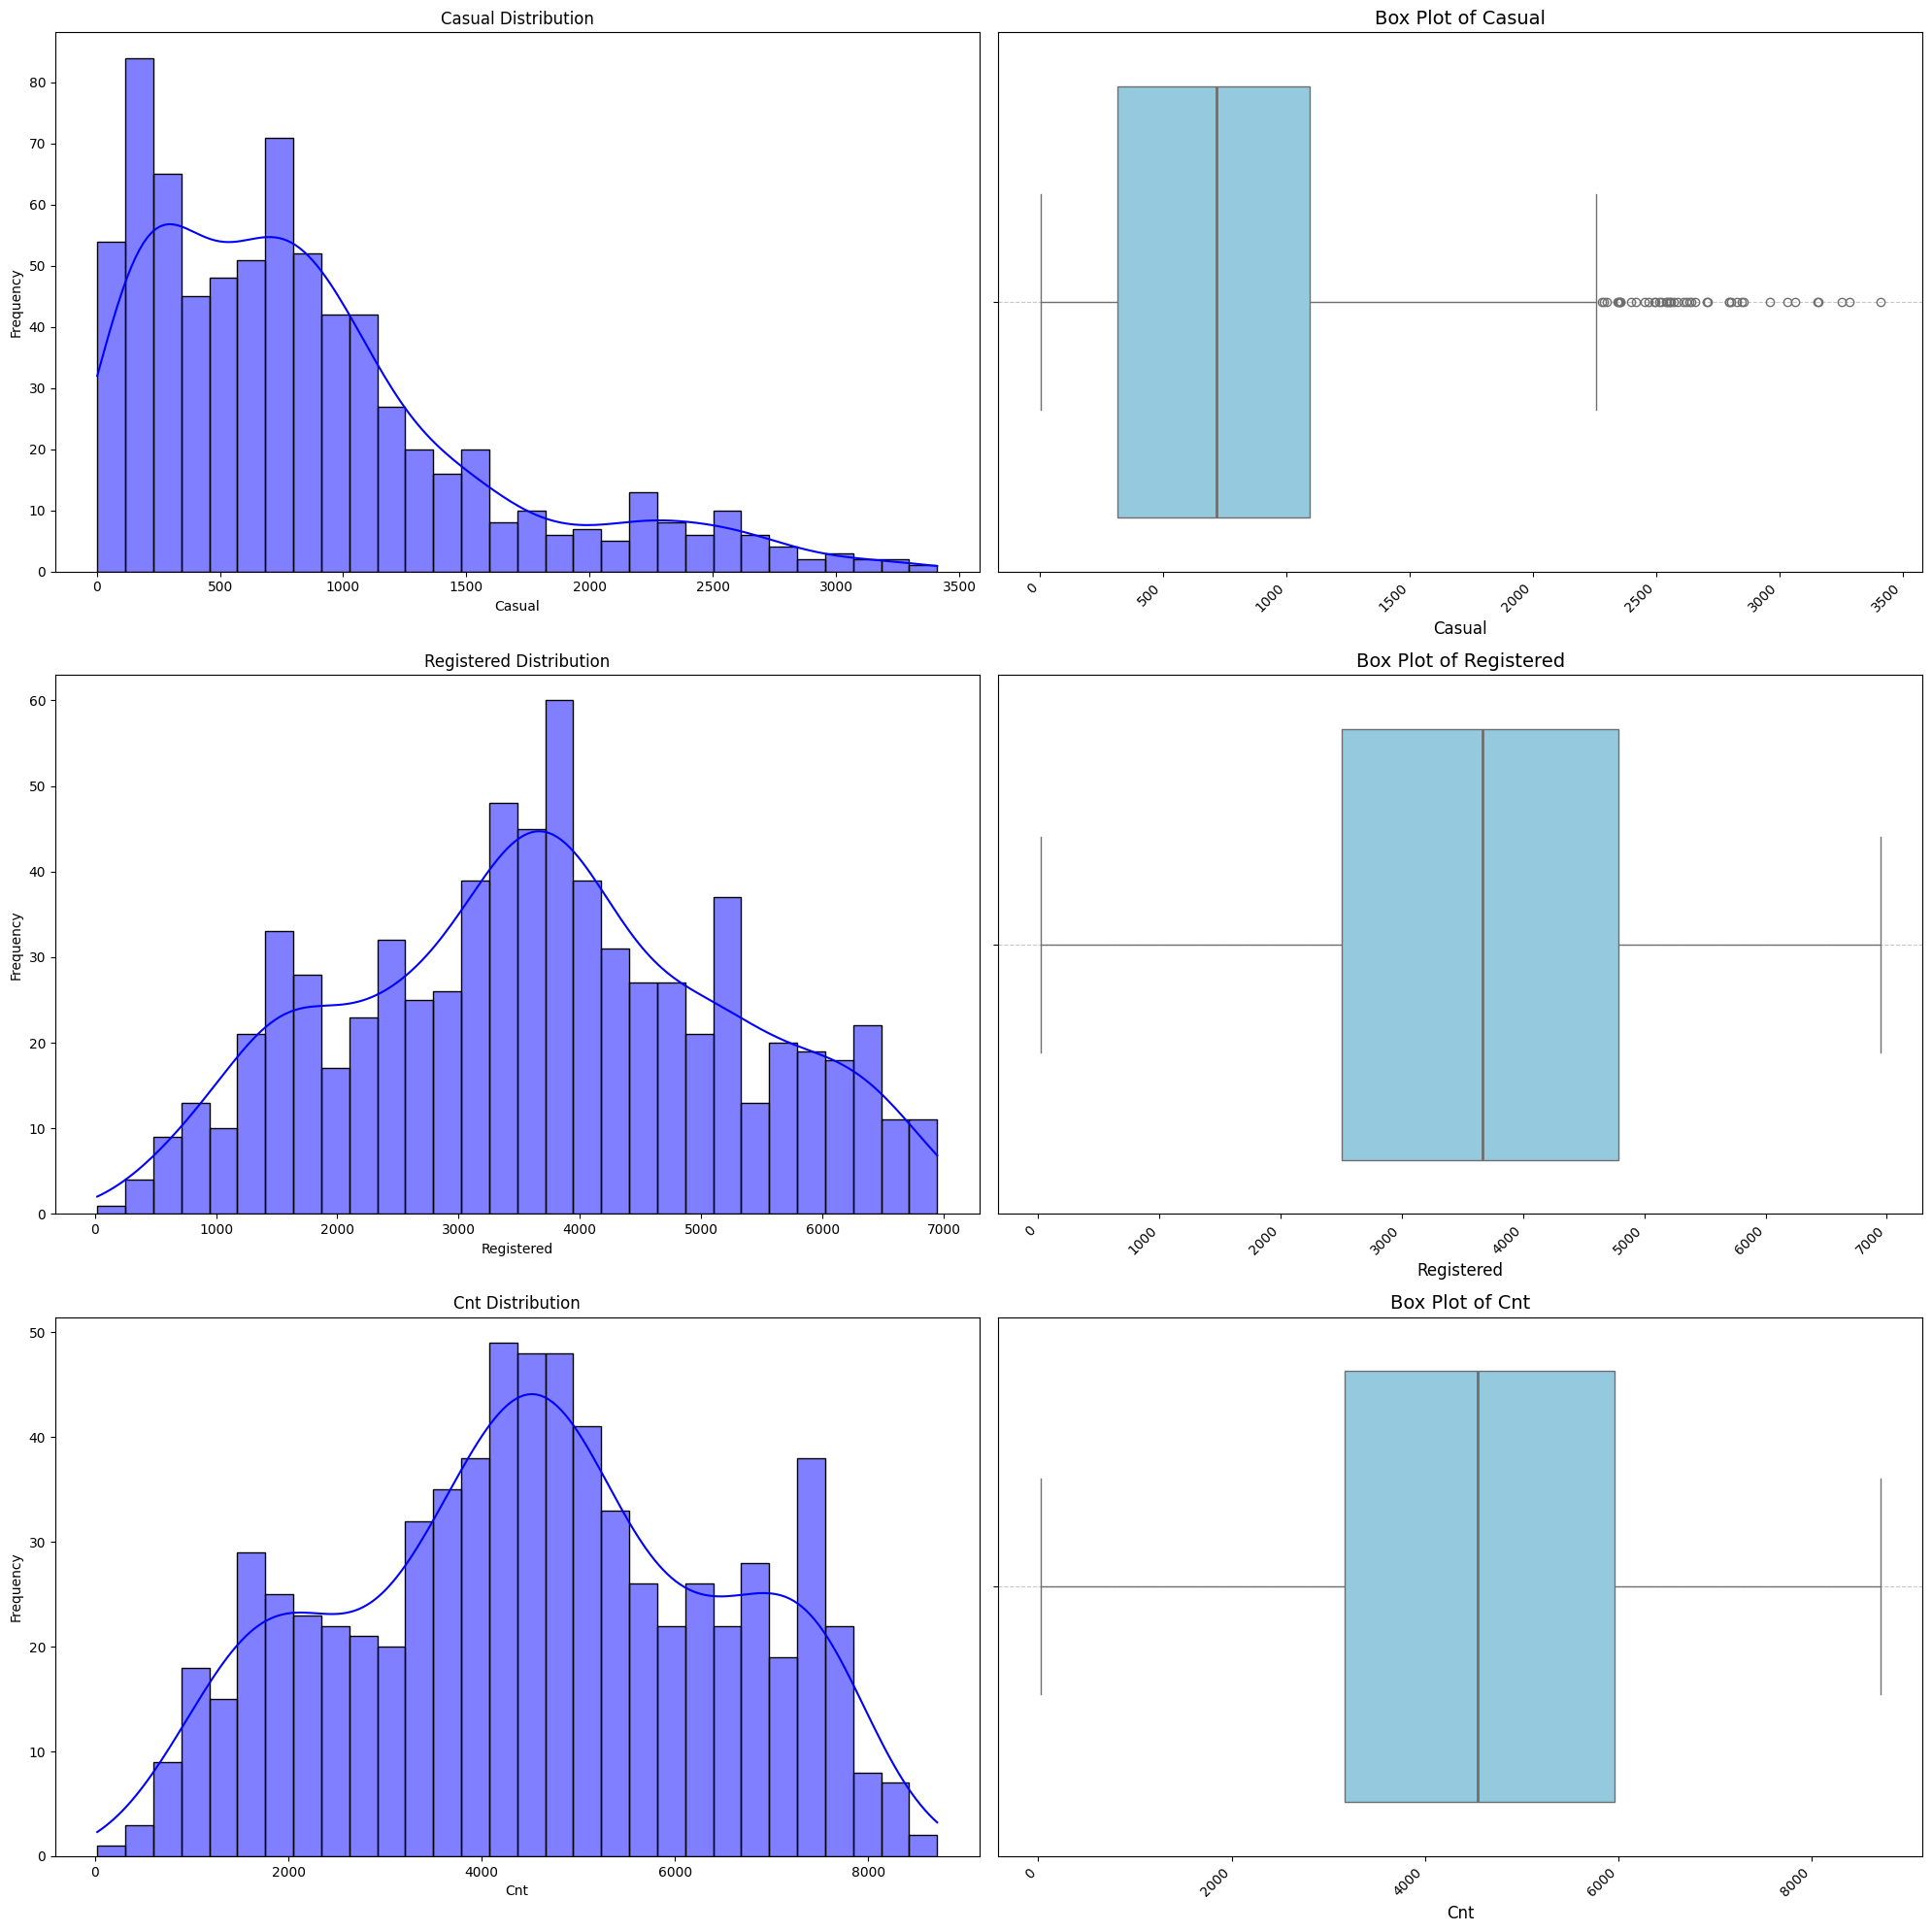

In [17]:
plt.figure(figsize=(20,20))
get_outlier_count(bike_df, 'casual') 
plt.subplot(3, 2, 1)
visualize_histplot_minimal(bike_df, 'casual', is_subplot= True)
plt.subplot(3, 2, 2)
visualize_boxplot_minimal(bike_df, 'casual', is_subplot= True)

get_outlier_count(bike_df, 'registered') 
plt.subplot(3, 2, 3)
visualize_histplot_minimal(bike_df, 'registered', is_subplot= True)
plt.subplot(3, 2, 4)
visualize_boxplot_minimal(bike_df, 'registered', is_subplot= True)

get_outlier_count(bike_df, 'cnt') 
plt.subplot(3, 2, 5)
visualize_histplot_minimal(bike_df, 'cnt', is_subplot= True)
plt.subplot(3, 2, 6)
visualize_boxplot_minimal(bike_df, 'cnt', is_subplot= True)
plt.show()

#### 📍Key Observations:
- **Casual Users:** Count of causal users are comparatively less then registered users. Data is left skewed. Casual users data has some outliers, but this can be a indication of sudden demand change due to event like holiday/weekend/ similar event which gather crowd.
- **Registered Users:** Count of registered users are comparatively higher then Casual users. Data is normally distributed. No outliers found.

> We'll keep outliers in our analysis because they might highlight potential demand for shared bikes. <br>
> These outliers could represent demand for shared bikes casual user to registered user transition.

## 🔆Analysis of Target columns (`Casual`, `Registered`, `Count`)

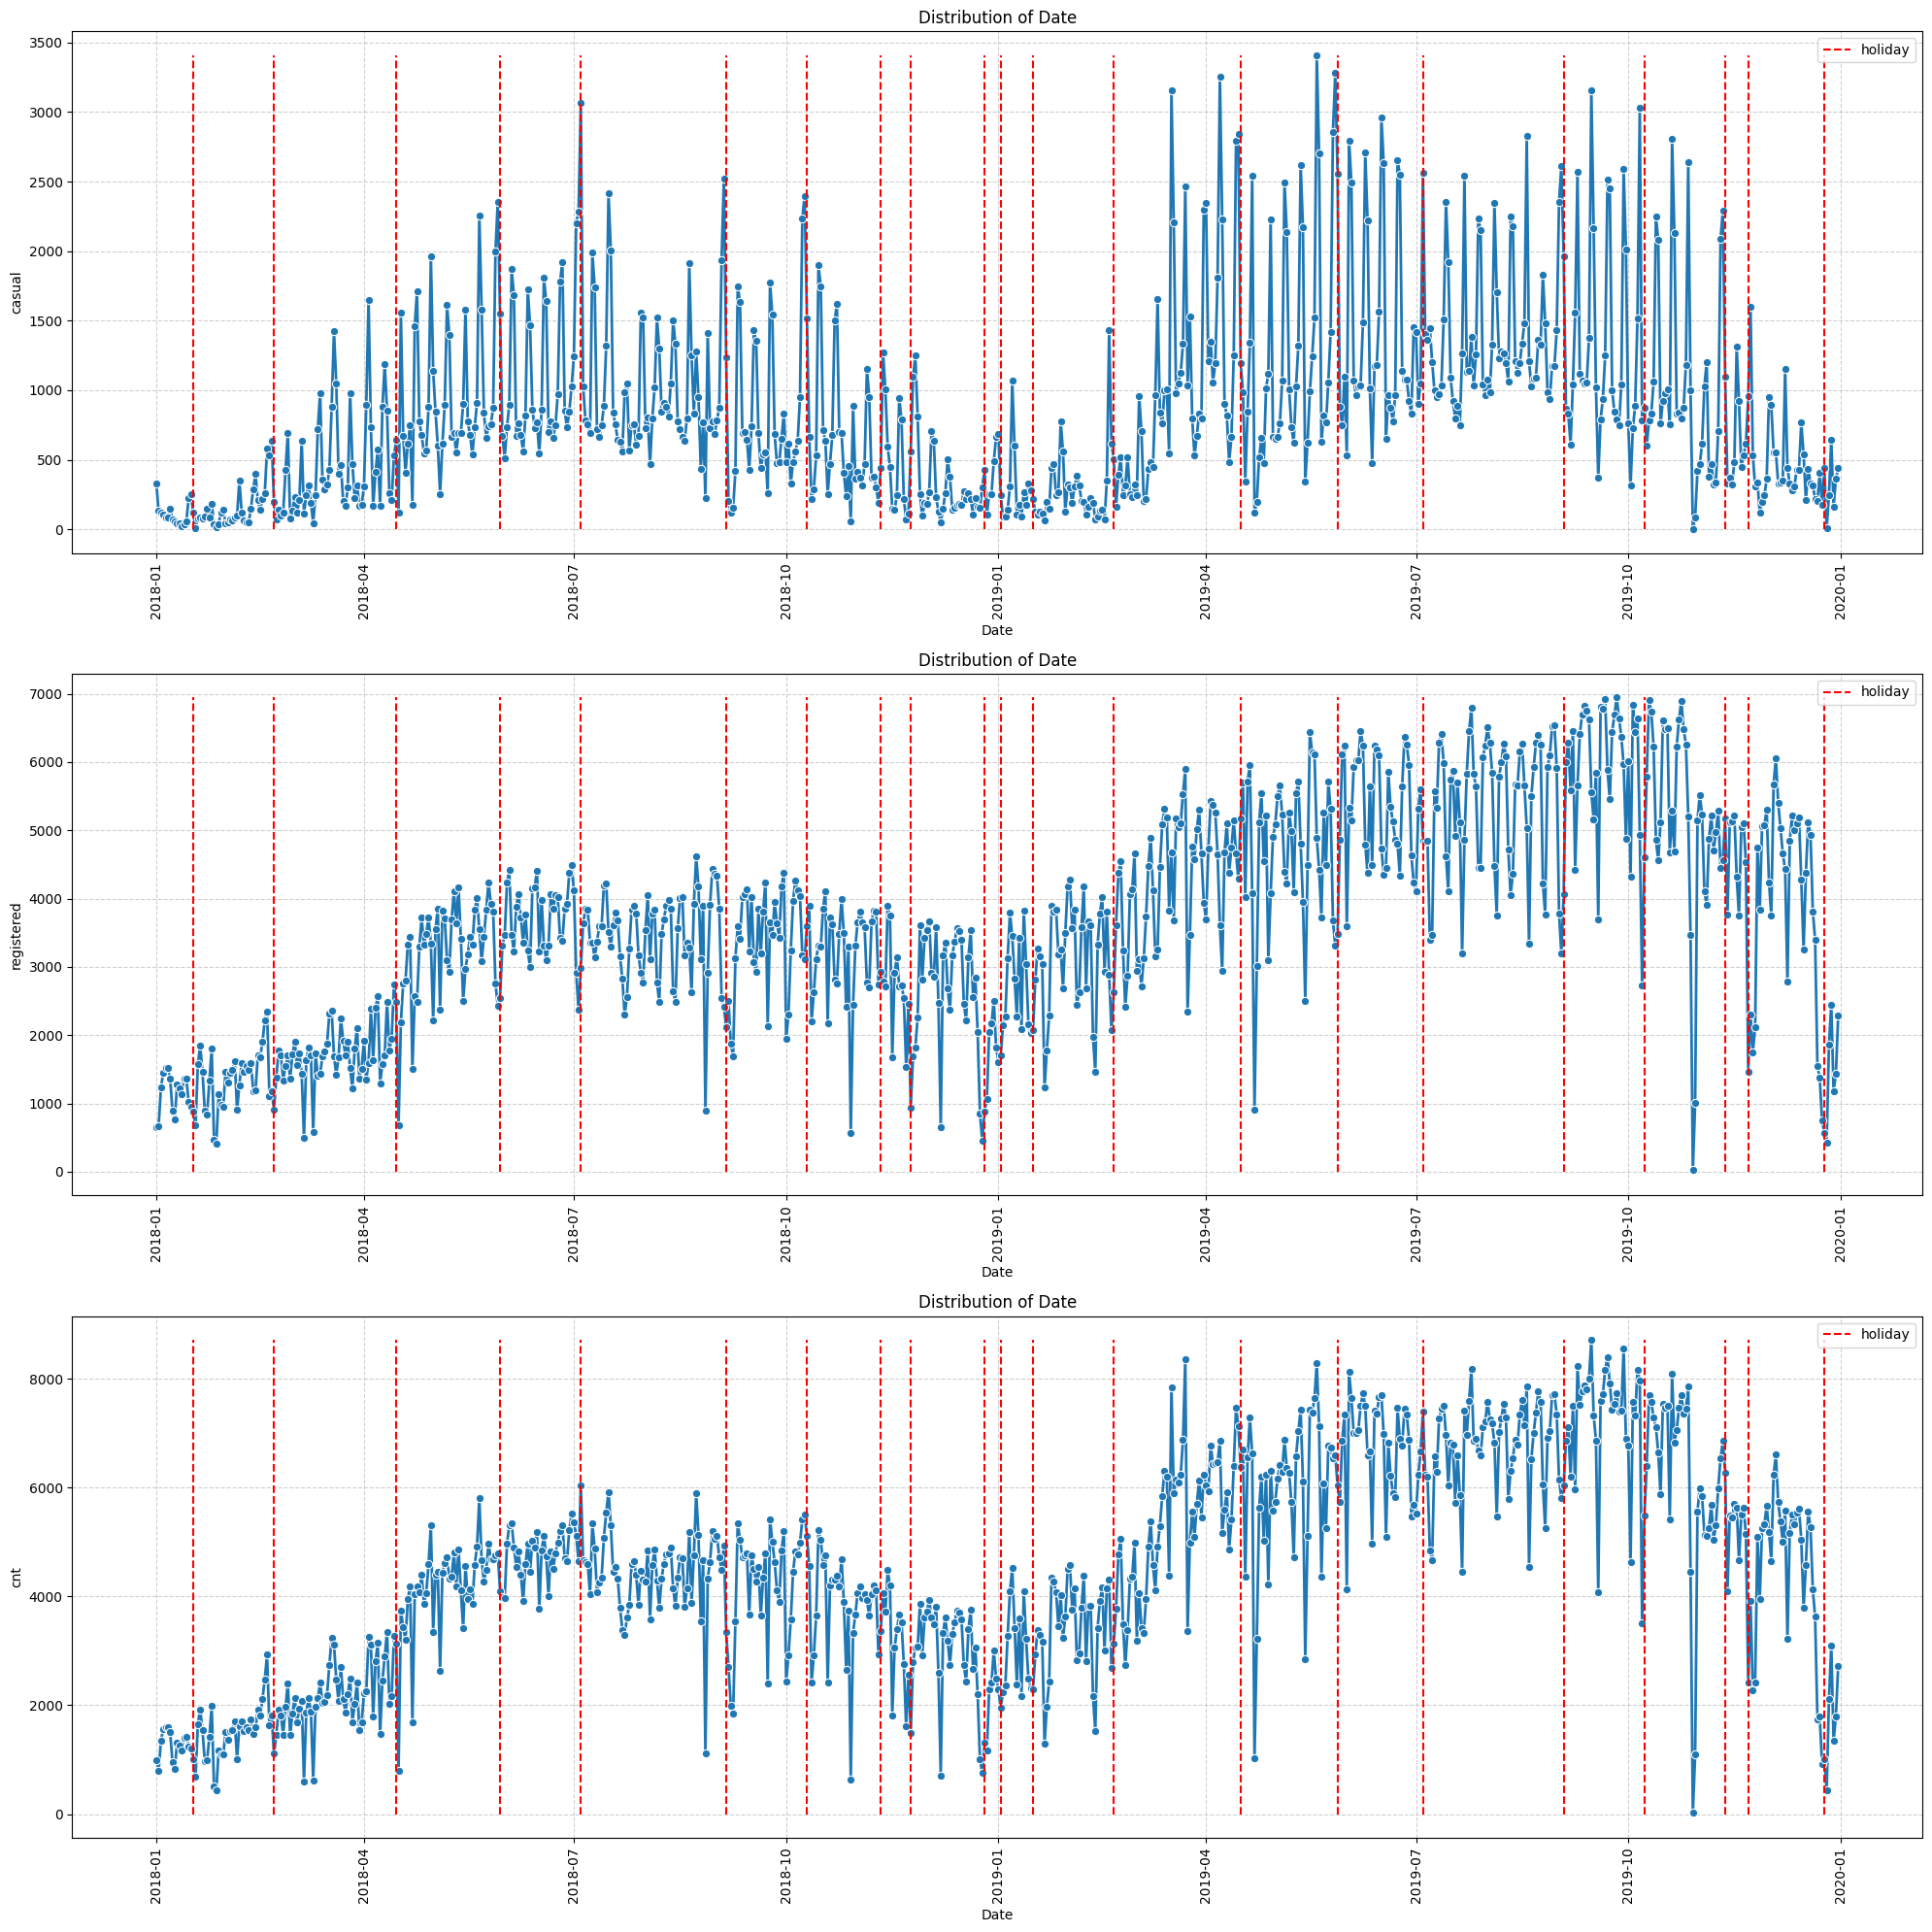

In [18]:
# Plot boxplots to see the effect of categorical variables on 'cnt'
plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
visualize_lineplot_minimal(bike_df, 'date', 'casual', is_subplot= True)
plt.vlines(x = 'date', data= bike_df[bike_df['holiday'] == True], ymin=0, ymax=bike_df['casual'].max(), colors='r', linestyles='--', label='holiday')
plt.legend()
plt.subplot(3, 1, 2)
visualize_lineplot_minimal(bike_df, 'date', 'registered', is_subplot= True)
plt.vlines(x = 'date', data= bike_df[bike_df['holiday'] == True], ymin=0, ymax=bike_df['registered'].max(), colors='r', linestyles='--', label='holiday')
plt.legend()
plt.subplot(3, 1, 3)
visualize_lineplot_minimal(bike_df, 'date', 'cnt', is_subplot= True)
plt.vlines(x = 'date', data= bike_df[bike_df['holiday'] == True], ymin=0, ymax=bike_df['cnt'].max(), colors='r', linestyles='--', label='holiday')
plt.legend()
plt.show()

#### Observation:
- General observation on all target variable is start of every hear drop in demand can be seen.
- Holidays don't see any impact on demand.
- In `Casual` users sudden spike in data is seen in middle of year. and over the months and year growth in sudden spikes.
- In `Registered` and `Total` Users gradually increasing over the period of time, during May, June, July of both year has high user demand remain stable till October.

In [19]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        730 non-null    datetime64[ns]
 1   season      730 non-null    category      
 2   year        730 non-null    category      
 3   month       730 non-null    category      
 4   weekday     730 non-null    category      
 5   holiday     730 non-null    category      
 6   workingday  730 non-null    category      
 7   weathersit  730 non-null    category      
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  casual      730 non-null    int64         
 13  registered  730 non-null    int64         
 14  cnt         730 non-null    int64         
dtypes: category(7), datetime64[ns](1), float64(4), int64(3)
memory usage: 52.1

In [20]:
# Let's list all categorical Variables
categorical_vars = list(bike_df.columns[bike_df.dtypes == 'category'])
print("List of Categorical Variables are :", categorical_vars)

print(" ")

# Let's list all continuous Variables
continuous_vars = list(bike_df.columns[bike_df.dtypes != 'category'])
print("List of Continuous Variables are :", continuous_vars)

print(" ")
print("Number of Rows in dataset:", bike_df.shape[0])
print("Number of Columns in dataset:",bike_df.shape[1])

List of Categorical Variables are : ['season', 'year', 'month', 'weekday', 'holiday', 'workingday', 'weathersit']
 
List of Continuous Variables are : ['date', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
 
Number of Rows in dataset: 730
Number of Columns in dataset: 15


## Data Visualization

##### Lets visualize the variables and their pattern w.r.t `casual`, `registered`, `cnt` (output Variable)

Let's now spend some time doing what is arguably the most important step - **understanding the data.**

In [21]:
bike_tmp_num_df = bike_df.copy(deep=True)

bike_tmp_num_df['season'] = remap_categorical_to_numeric(bike_tmp_num_df, 'season', SEASON_MAPPINGS)
bike_tmp_num_df['month'] = remap_categorical_to_numeric(bike_tmp_num_df, 'month', MONTH_MAPPINGS)
bike_tmp_num_df['weekday'] = remap_categorical_to_numeric(bike_tmp_num_df, 'weekday', WEEKDAY_MAPPINGS)
bike_tmp_num_df['weathersit'] = remap_categorical_to_numeric(bike_tmp_num_df, 'weathersit', WEATHER_SIT_MAPPINGS)

bike_tmp_num_df['holiday'] = remap_categorical_to_numeric(bike_tmp_num_df, 'holiday', HOLIDAY_DAY_MAPPINGS)
bike_tmp_num_df['workingday'] = remap_categorical_to_numeric(bike_tmp_num_df, 'workingday', WORKING_DAY_MAPPINGS)

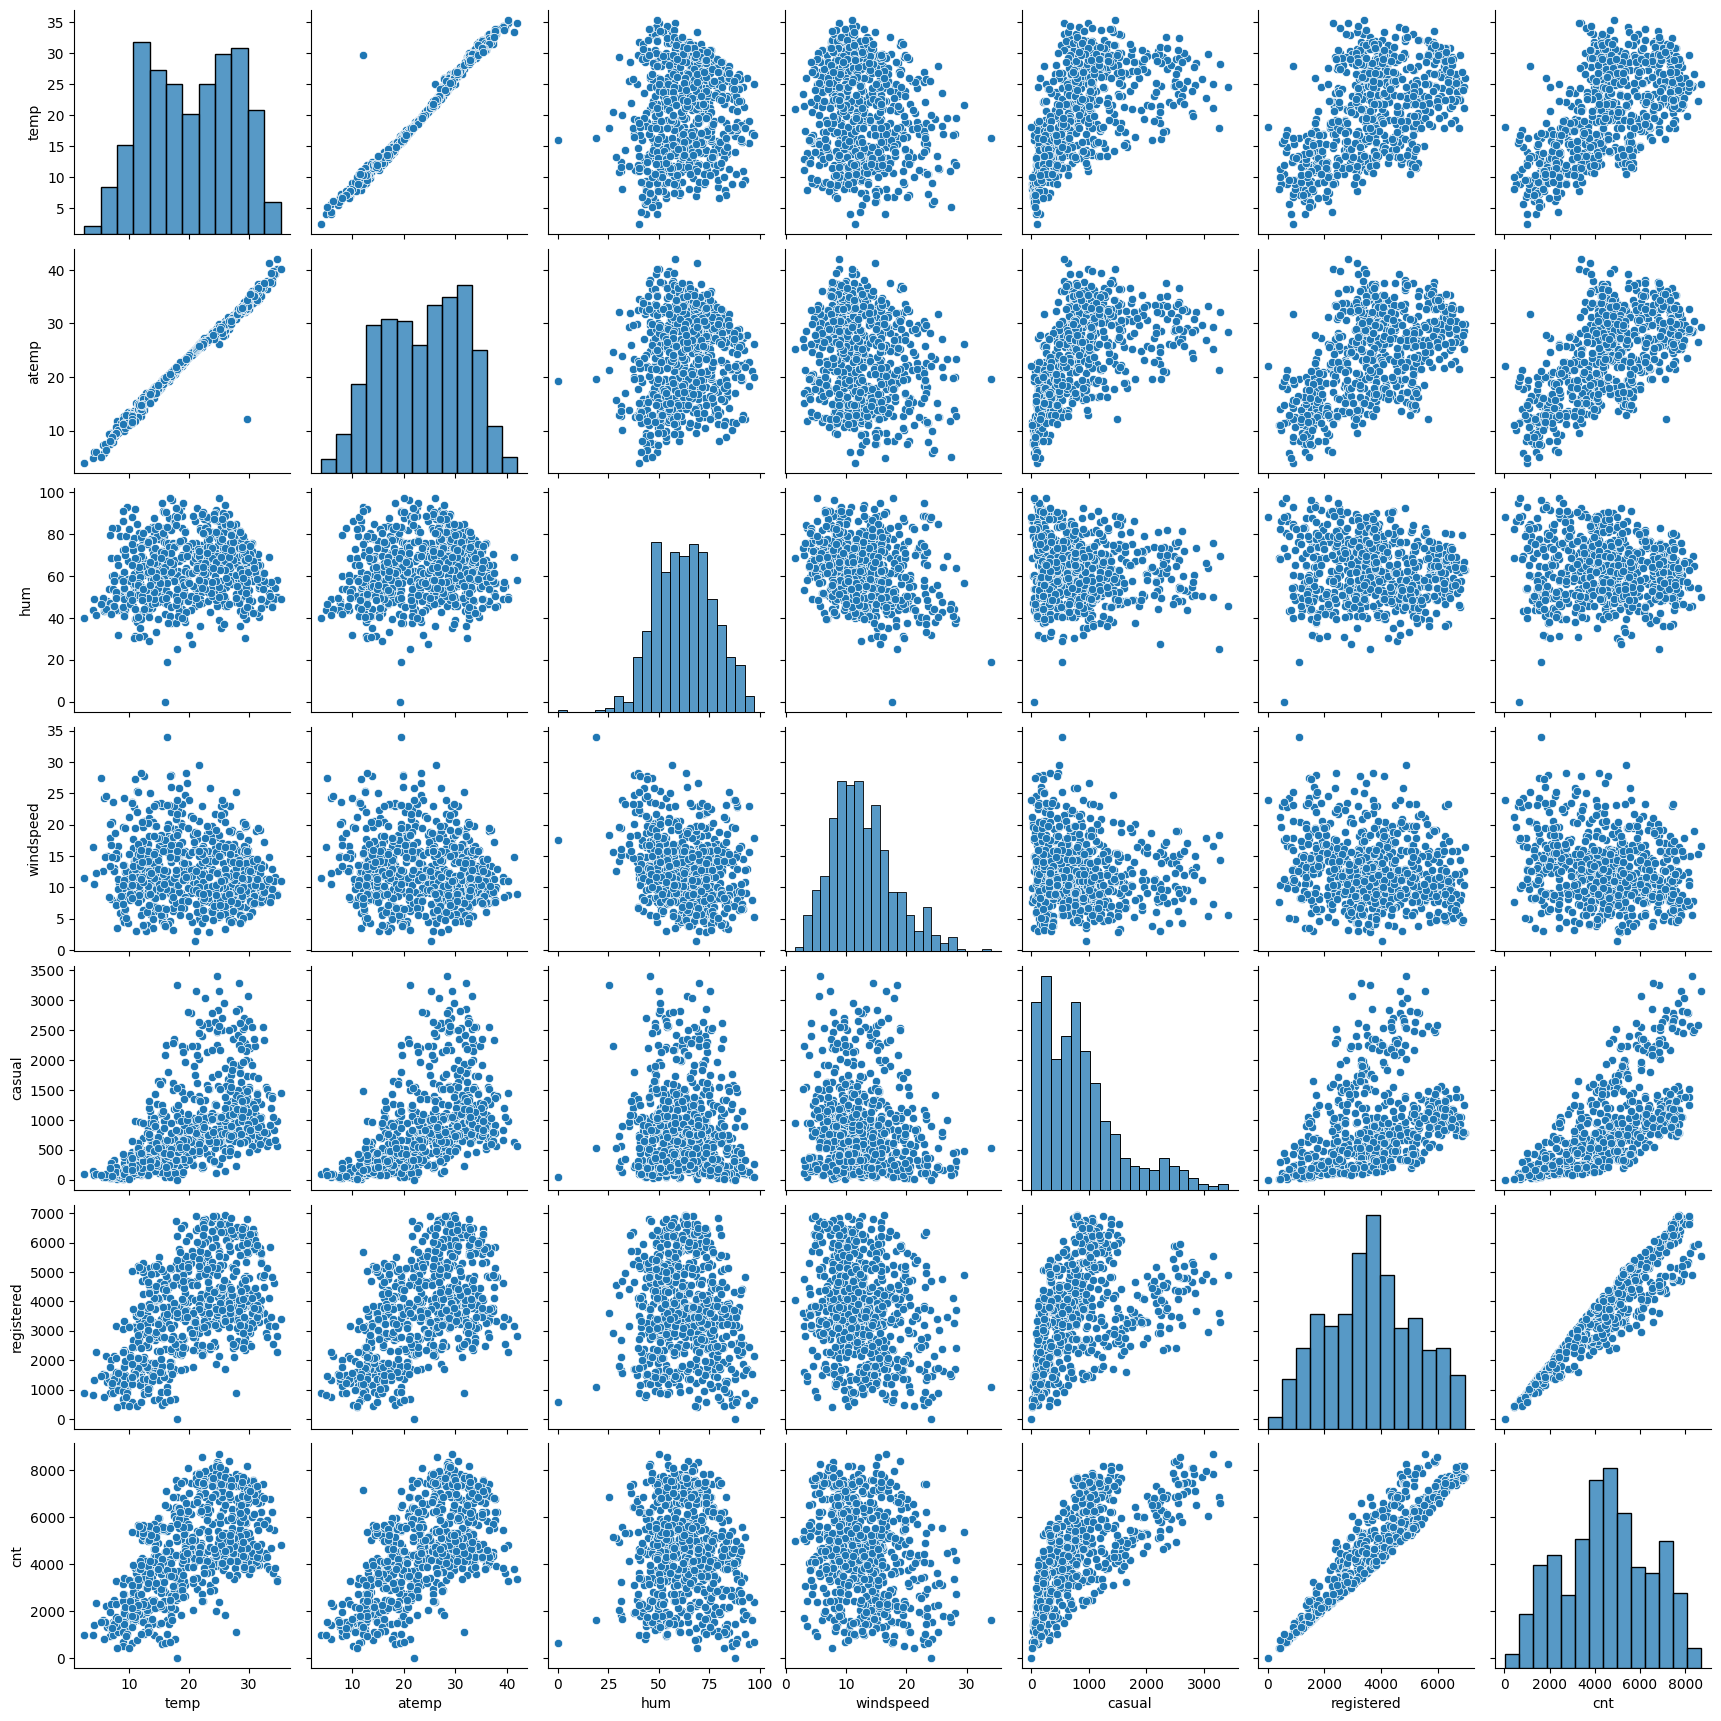

In [22]:
#Visualize the data using seaborn
sns.pairplot(bike_tmp_num_df)
plt.show()

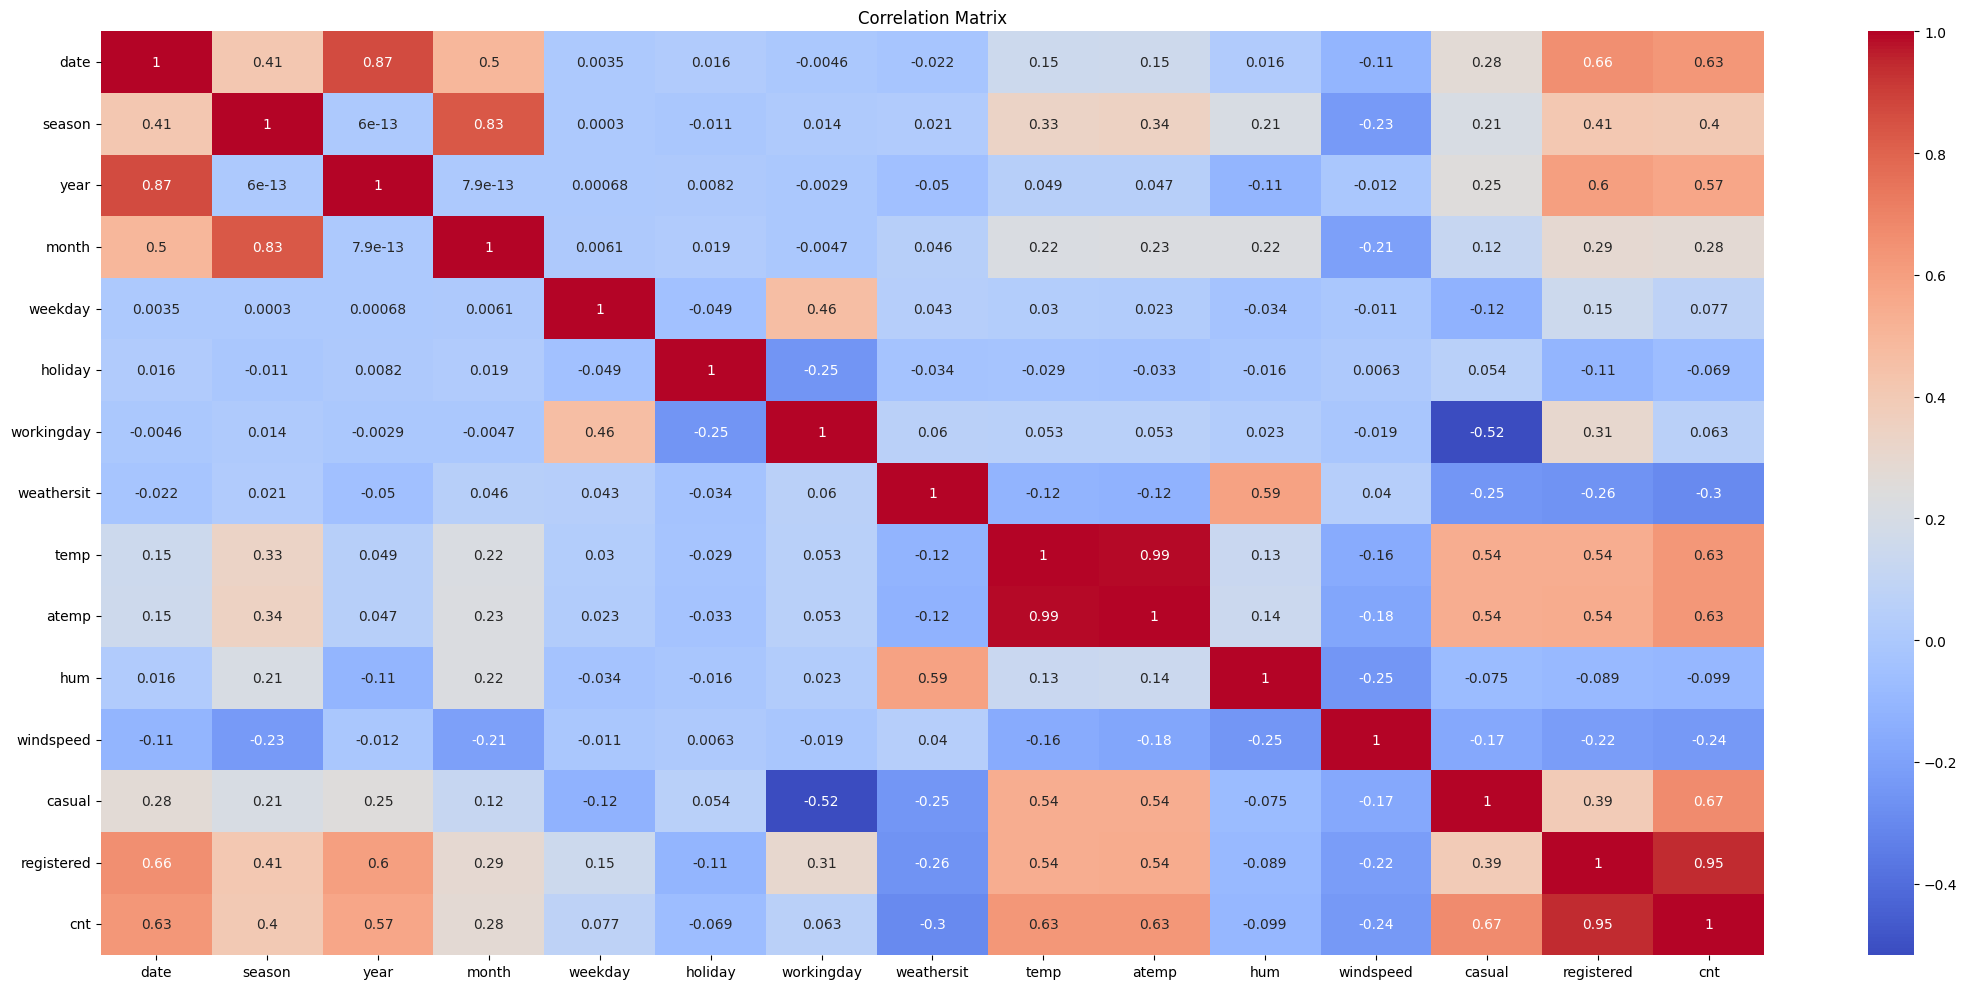

In [23]:
# Correlation matrix for numeric features
plt.figure(figsize=(22, 10))

corr = bike_tmp_num_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Insights:
Now, we have brief idea about which features are related to `casual`, `registered`, `cnt`. 

We can see some features have positive relationship with `casual`, `registered`, `cnt`. 

These are given as follows:
- date
- season
- year
- month
- temp
- atemp

However, there are some attributes that show a negative relationship w.r.t `casual`, `registered`, `cnt`:
- weathersit
- windspeed

We can also observe some multicollinearity visible between the predictor variables:
- date with season, year, month
- weekend with workday
- temp with atemp

### Detecting Outliers

date
temp
atemp
hum
windspeed


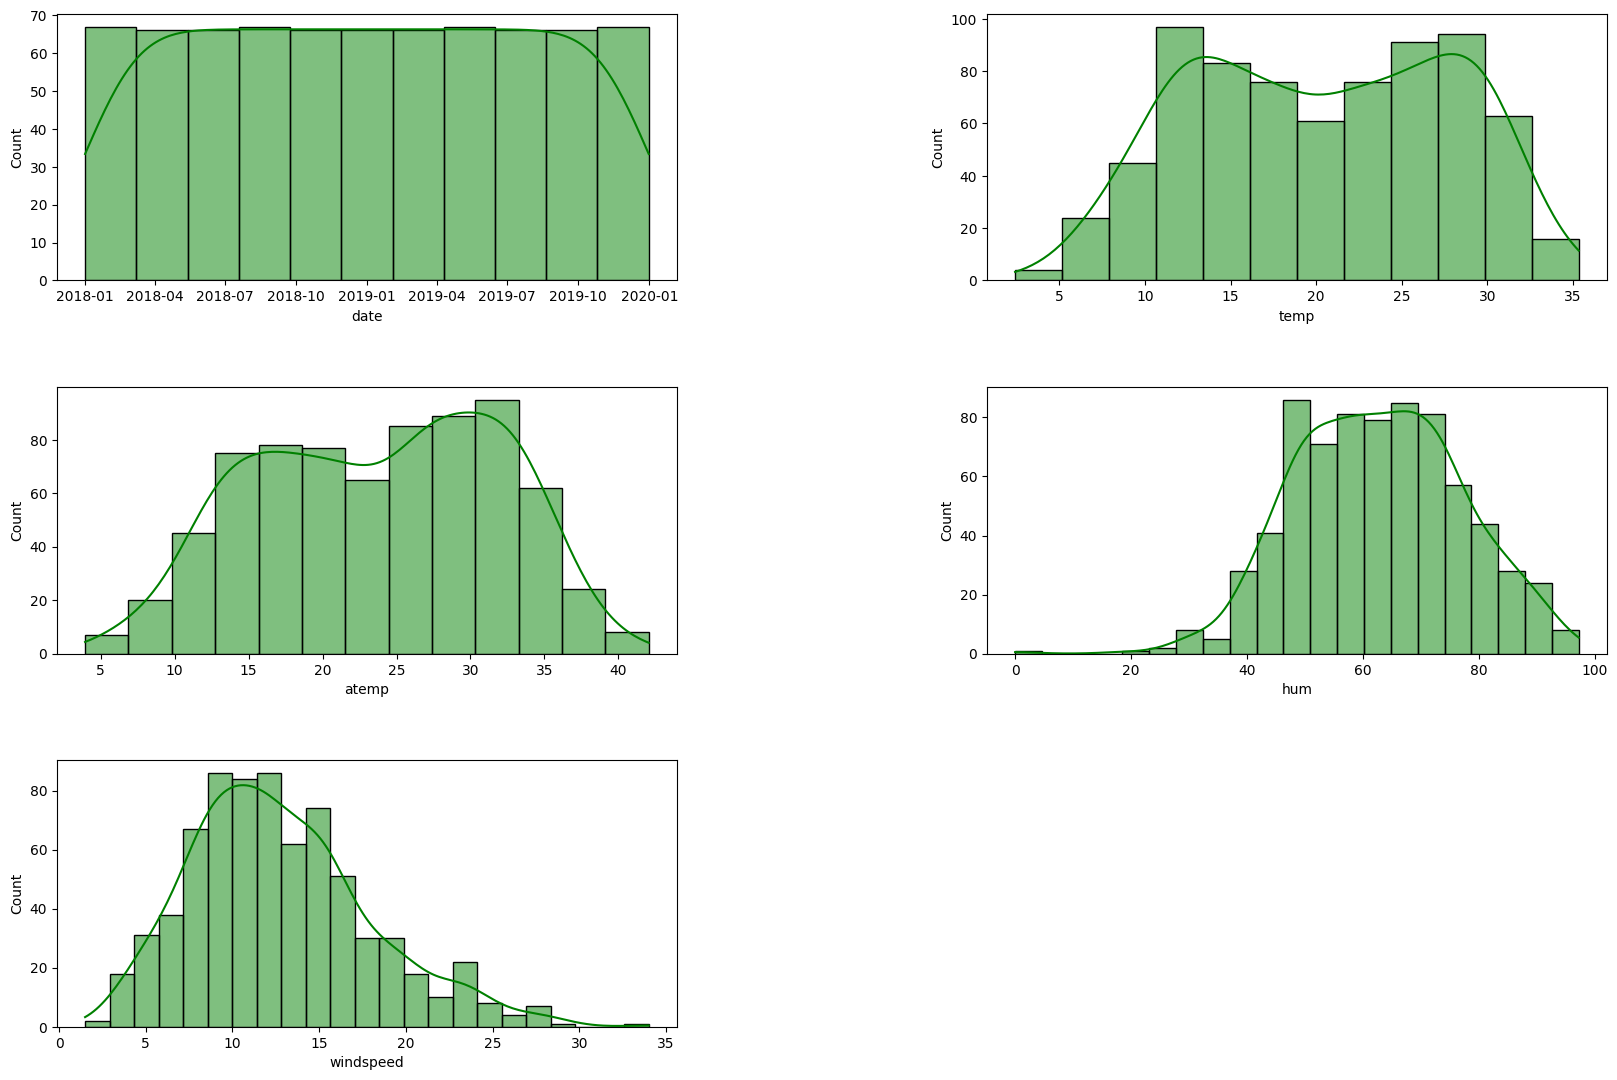

In [24]:
# Detecting outliers in continuous variables
numeric_list = list(bike_df.columns[bike_df.dtypes != 'category'])
counter = 1

plt.figure(figsize = (20, 18))

for col_list in numeric_list:
    
    if col_list not in ['casual', 'registered', 'cnt']:
        print(col_list)
        plt.subplot(4, 2, counter)
        sns.histplot(bike_df[col_list], kde = True, color = 'g')
        
        counter += 1

plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.5)
plt.show()

#### Insights: 
- There are all variables are not normally distributed, i.e., outliers are present. 
- Due to presence of less number of observation, we are not deleting some rows to correct the outliers. 
- We will be doing the scaling in data to correct this during Model preparation.

## Perform EDA on Prepared Dataset

### Univariate Analysis

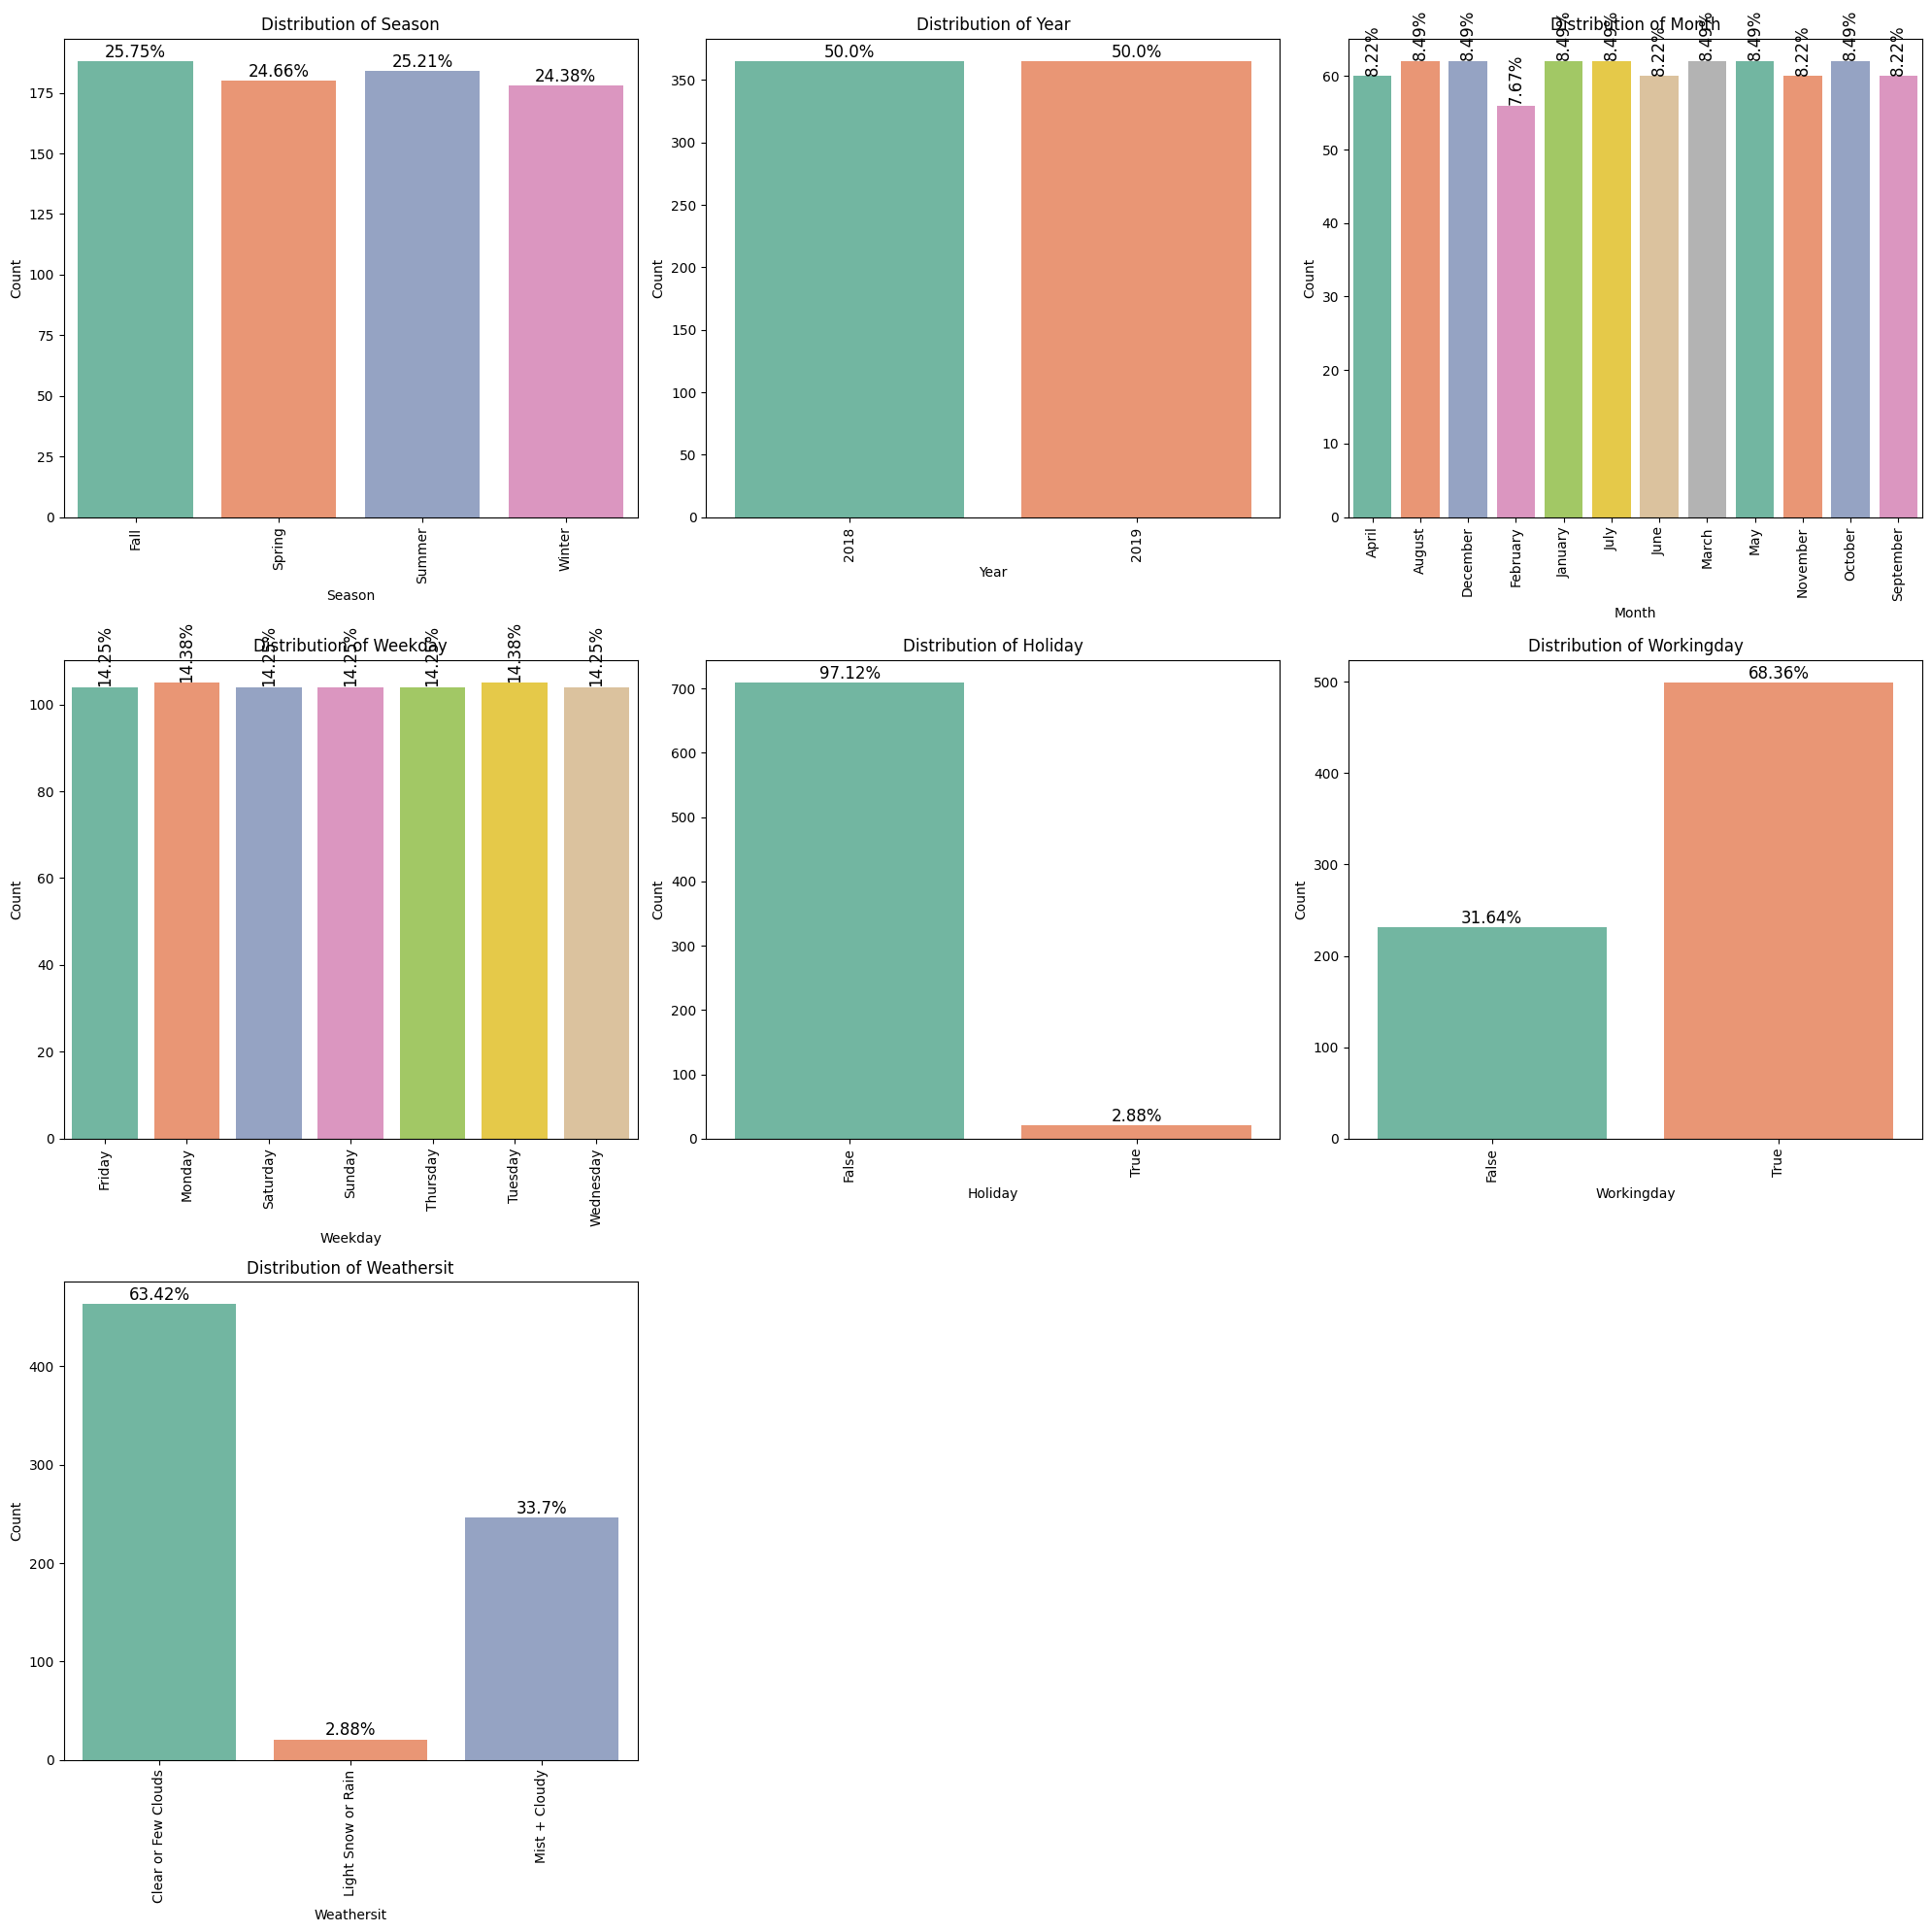

In [25]:
count = 1
plt.figure(figsize=(20, 20))
for col in categorical_cols:
    plt.subplot(3, 3, count)
    visualize_countplot_minimal(bike_df, col, is_subplot= True)
    count += 1

plt.tight_layout()
plt.show()

### Bivariate Analysis + multi variate analysis

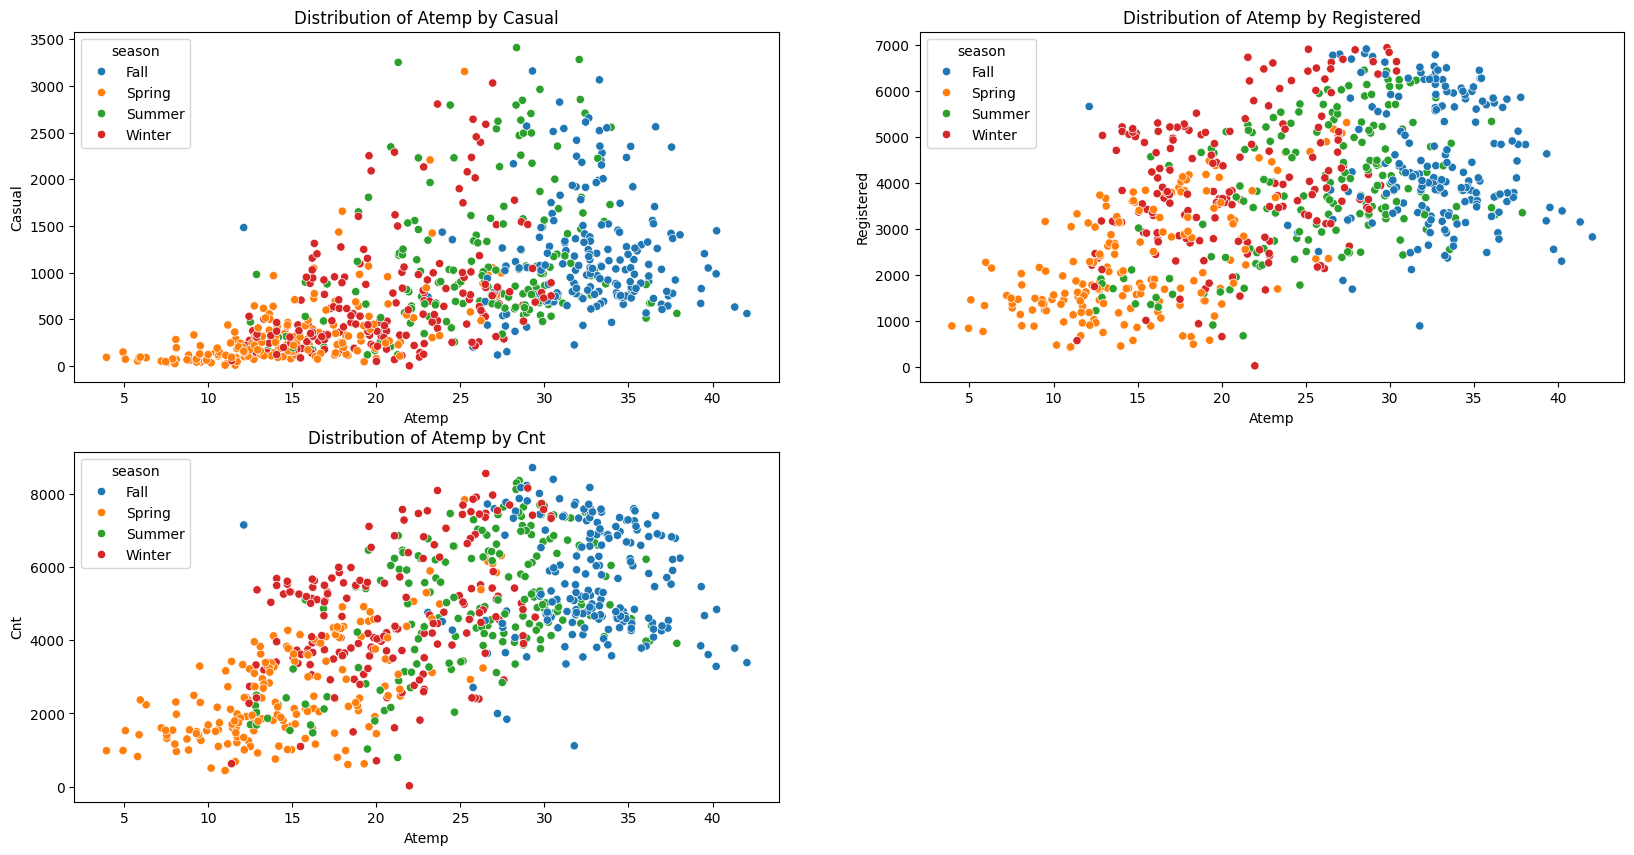

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'atemp', 'casual', 'season', is_subplot=True)
plt.subplot(2,2,2)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'atemp', 'registered', 'season', is_subplot=True)
plt.subplot(2,2,3)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'atemp', 'cnt', 'season', is_subplot=True)
plt.show()

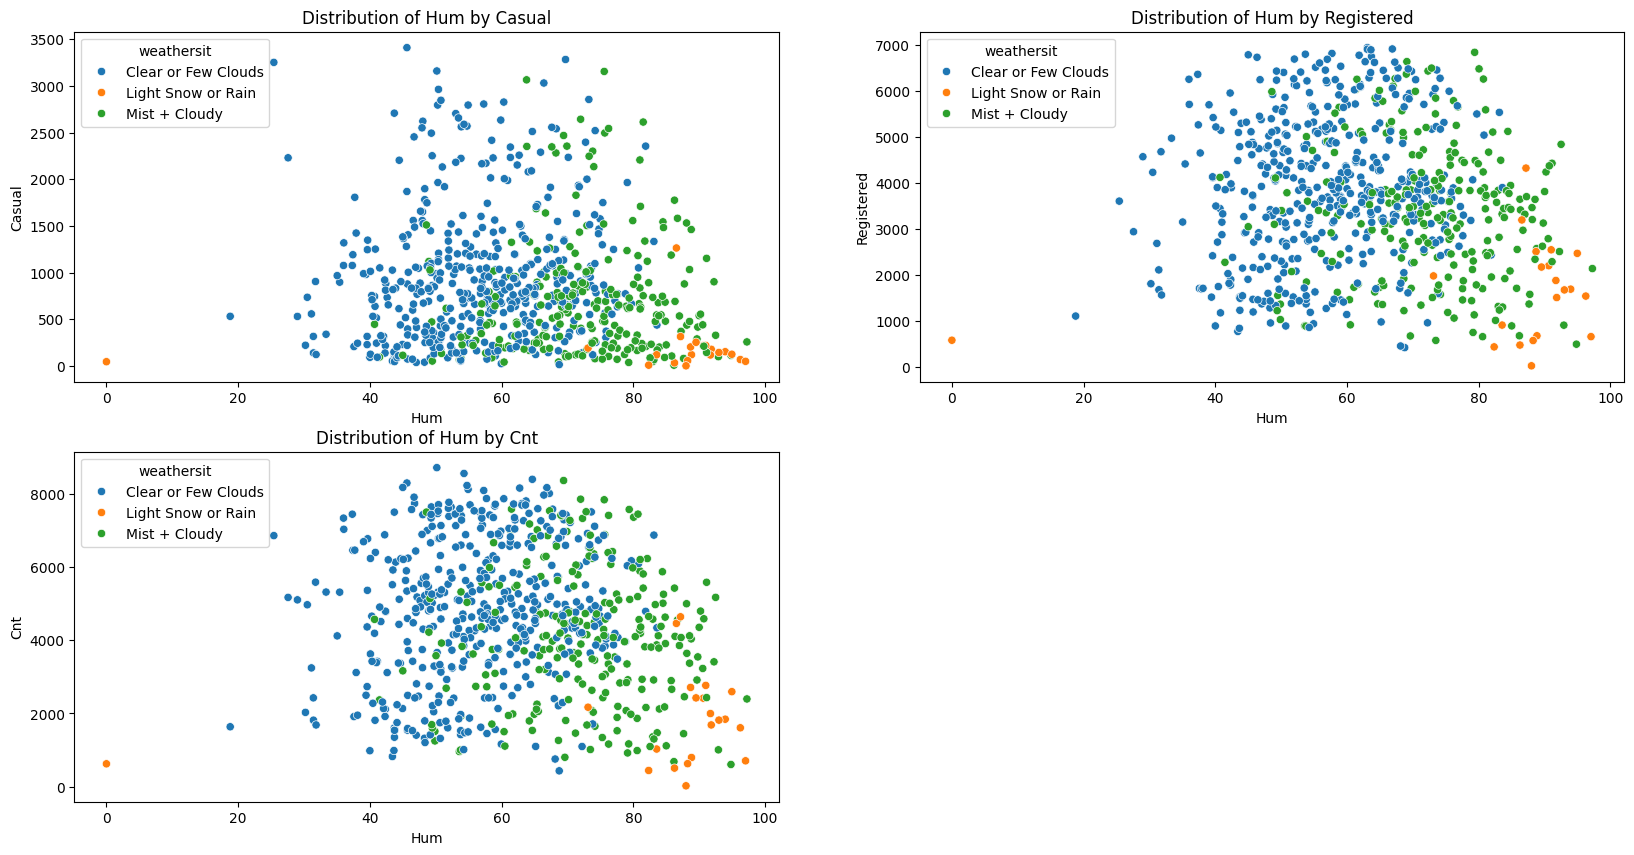

In [27]:

plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'hum', 'casual', 'weathersit', is_subplot=True)
plt.subplot(2,2,2)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'hum', 'registered', 'weathersit', is_subplot=True)
plt.subplot(2,2,3)
visualize_numerical_vs_numerical_on_categorical_hue(bike_df, 'hum', 'cnt', 'weathersit', is_subplot=True)
plt.show()

#### Insights: (Hum vs target variables vs weathersit)
- we can bin hum data 3 bins `hum > 80` as `High`, `80 > hum > 60` as `Medium`, `60 > hum` as `low` 

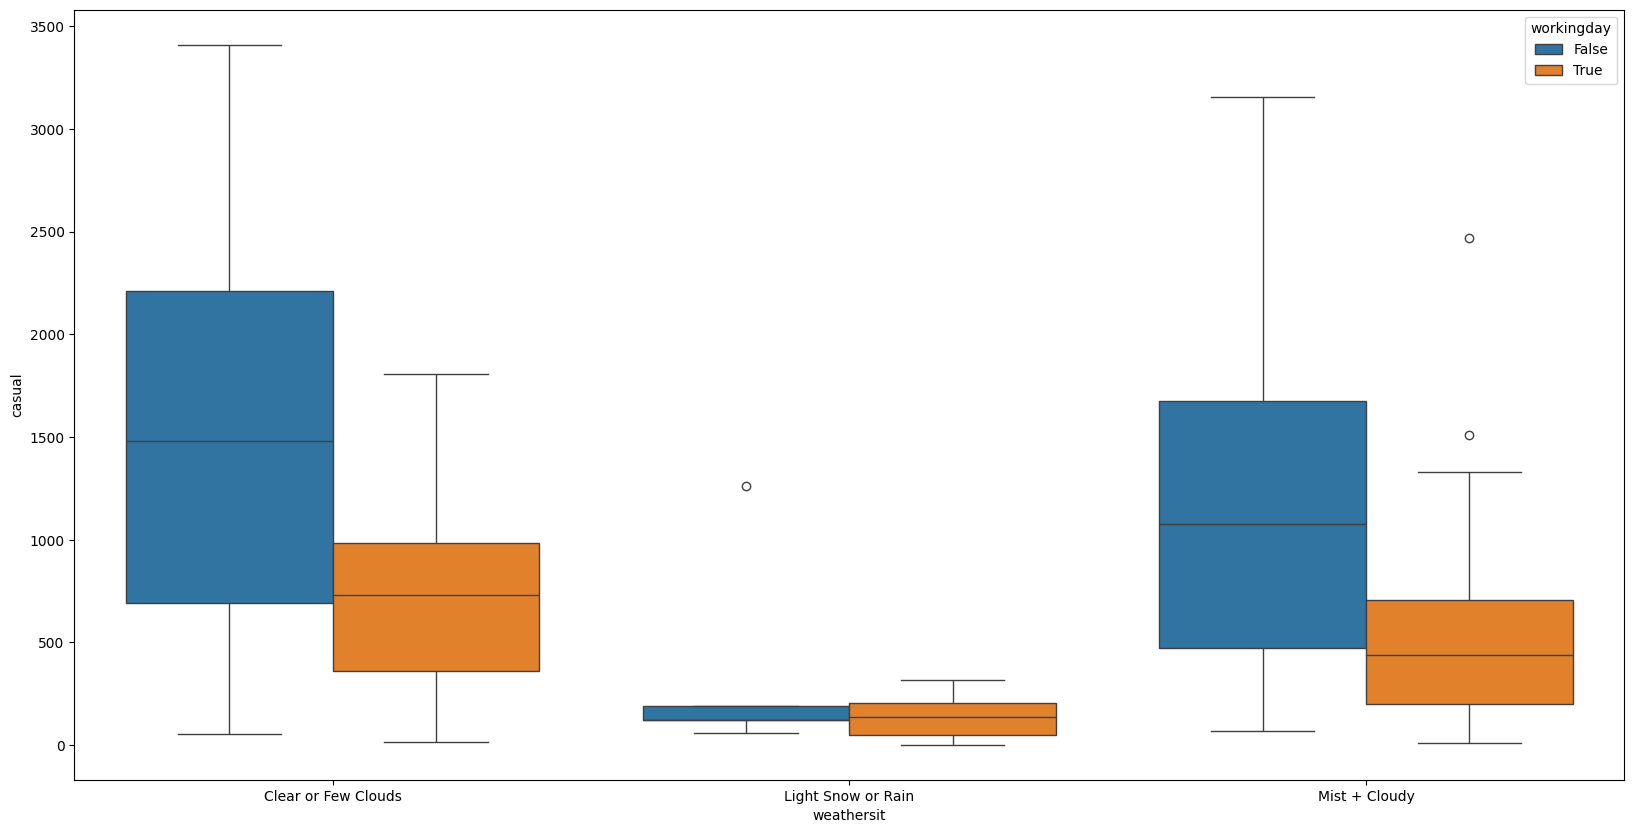

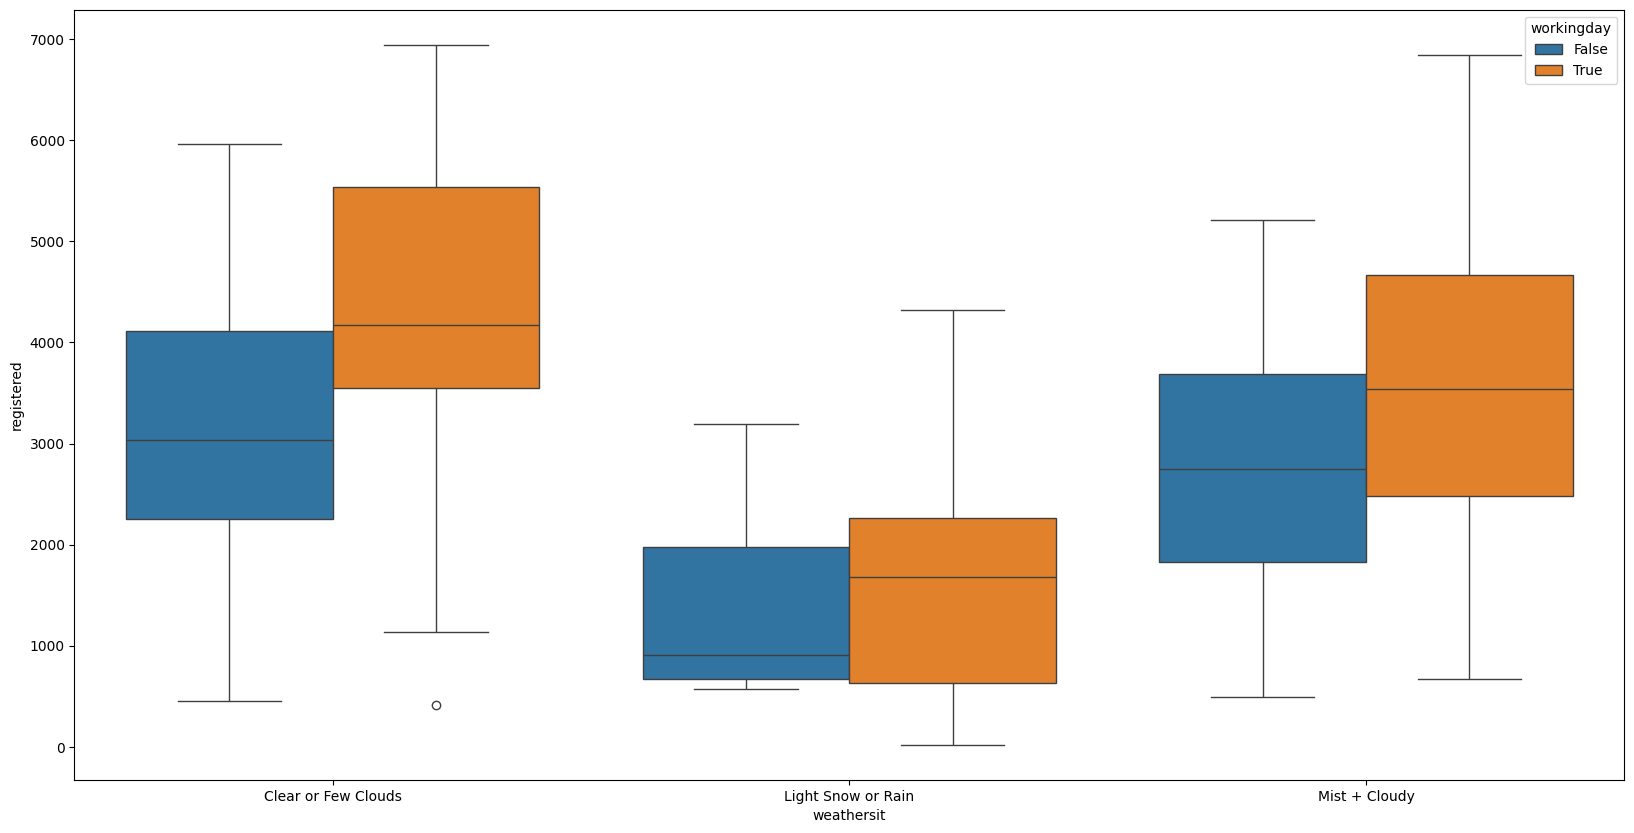

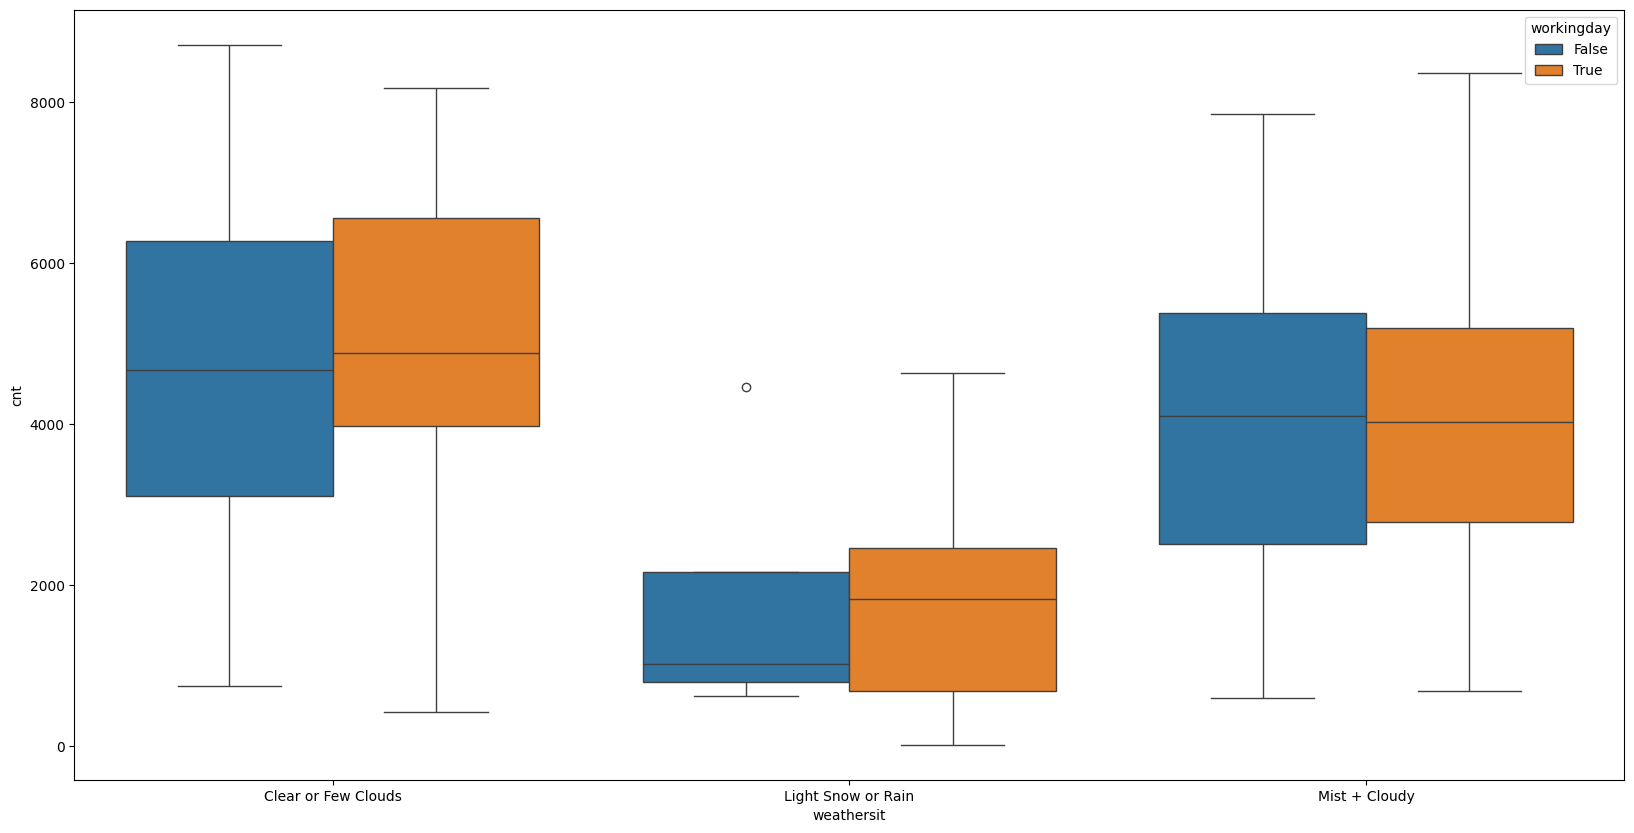

In [28]:
# Plotting of weathersit vs workingday w.r.t casual, registered, cnt
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='casual', hue = 'workingday', data=bike_df)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='registered', hue = 'workingday', data=bike_df)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='cnt', hue = 'workingday', data=bike_df)
plt.show()

#### Insights: (weather vs working day)
In case of `casual` users
- Demand drops when snow or rain happens.
- In Non working day all weather sit demand is on peak 

In case of `registered` users
- Demand drops when snow or rain happens.
- In working day all weather sit demand is on peak which is opposite to casual users.

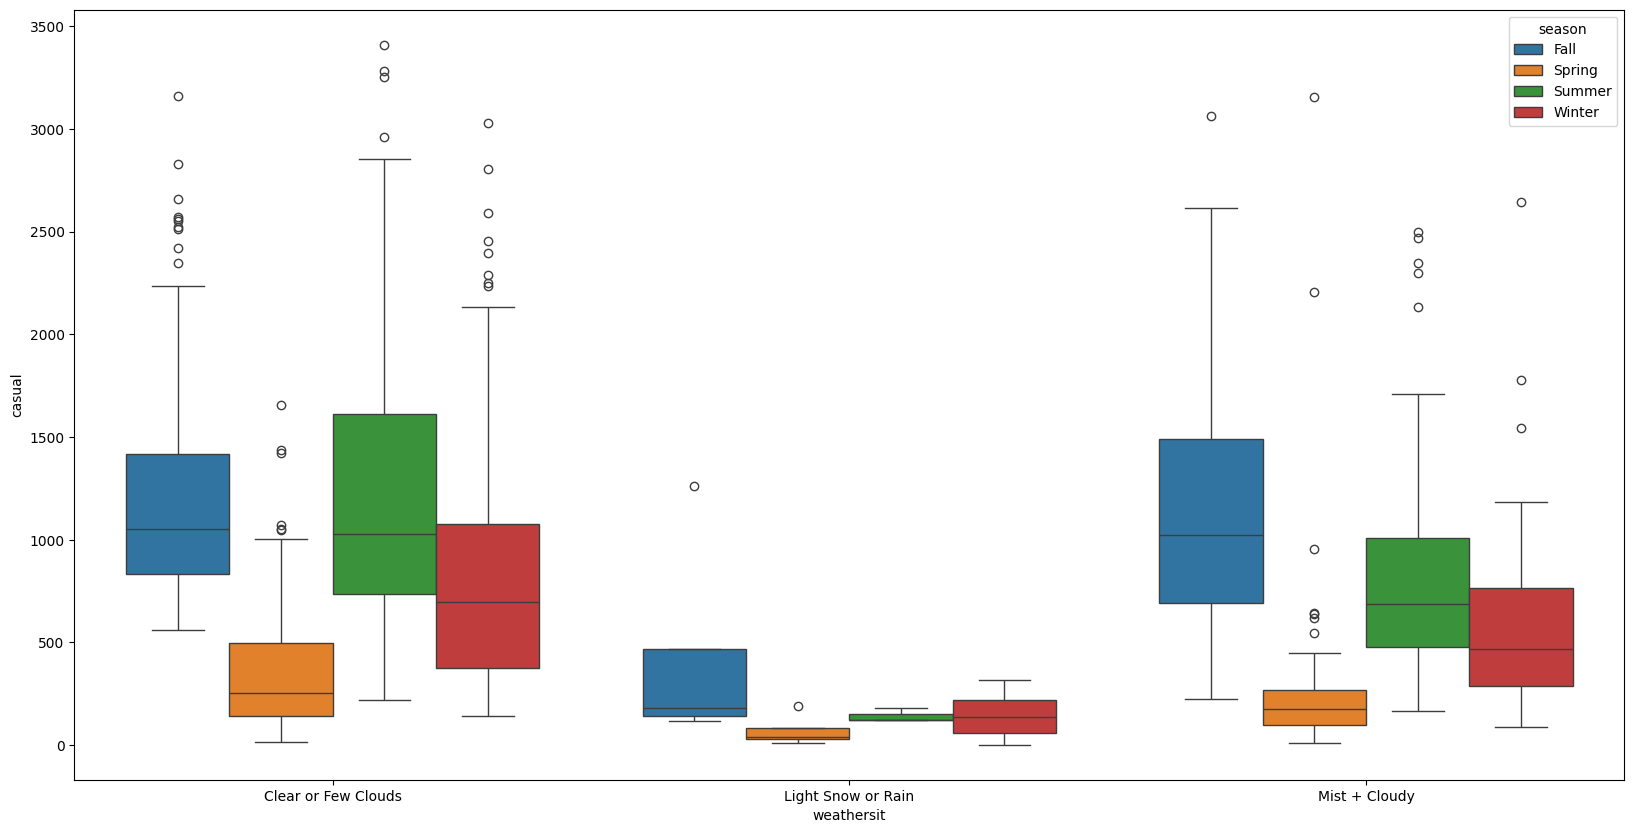

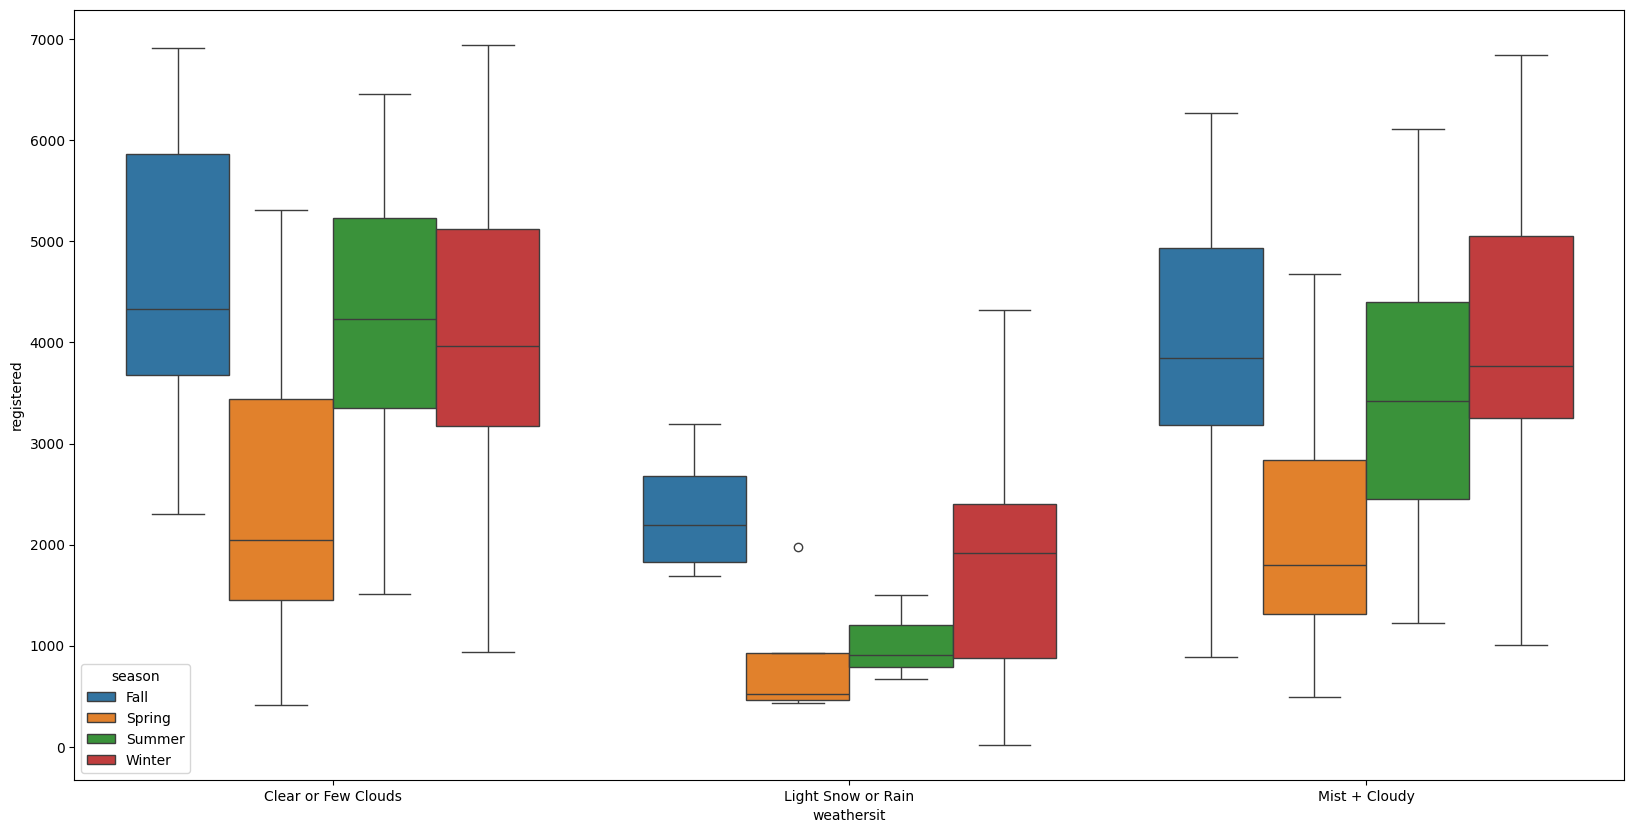

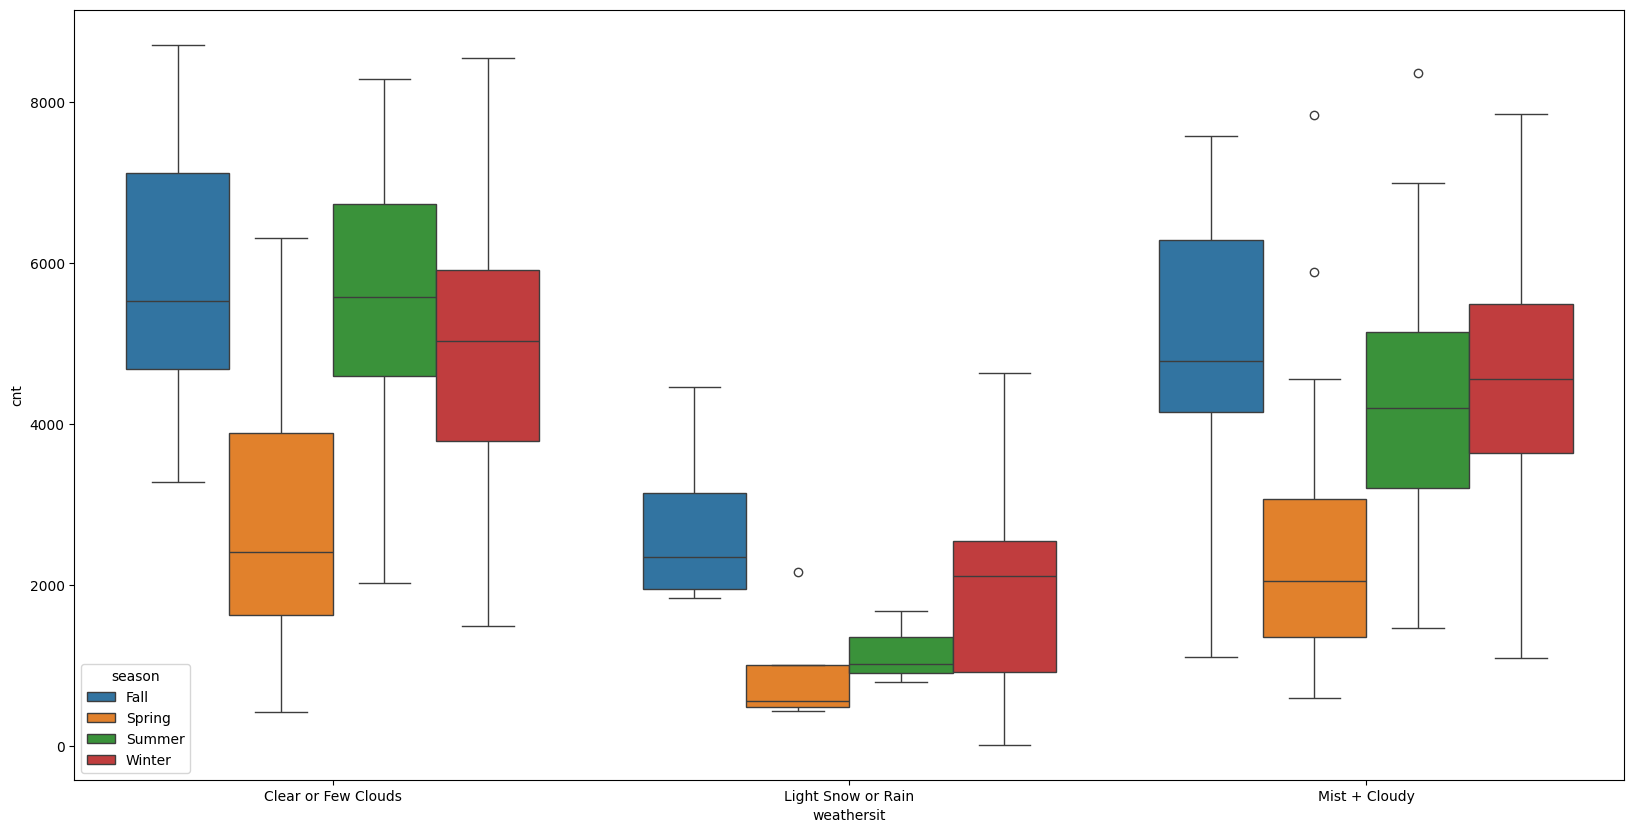

In [29]:
# Plotting of weathersit vs season w.r.t casual, registered, cnt
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='casual', hue = 'season', data=bike_df)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='registered', hue = 'season', data=bike_df)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='weathersit', y='cnt', hue = 'season', data=bike_df)
plt.show()

#### Insights: (weather sit vs season)
In case of `casual` users
- In summer season has high demand in clear or few clouds.
- On the other hand spring season has very low demand in all weather sit 
- Demand drops when snow or rain happens.

In case of `registered` users
- In fall season has high demand in all weather sit.
- On the other hand spring season has very low demand in all weather sit  
- Demand drops when snow or rain happens.

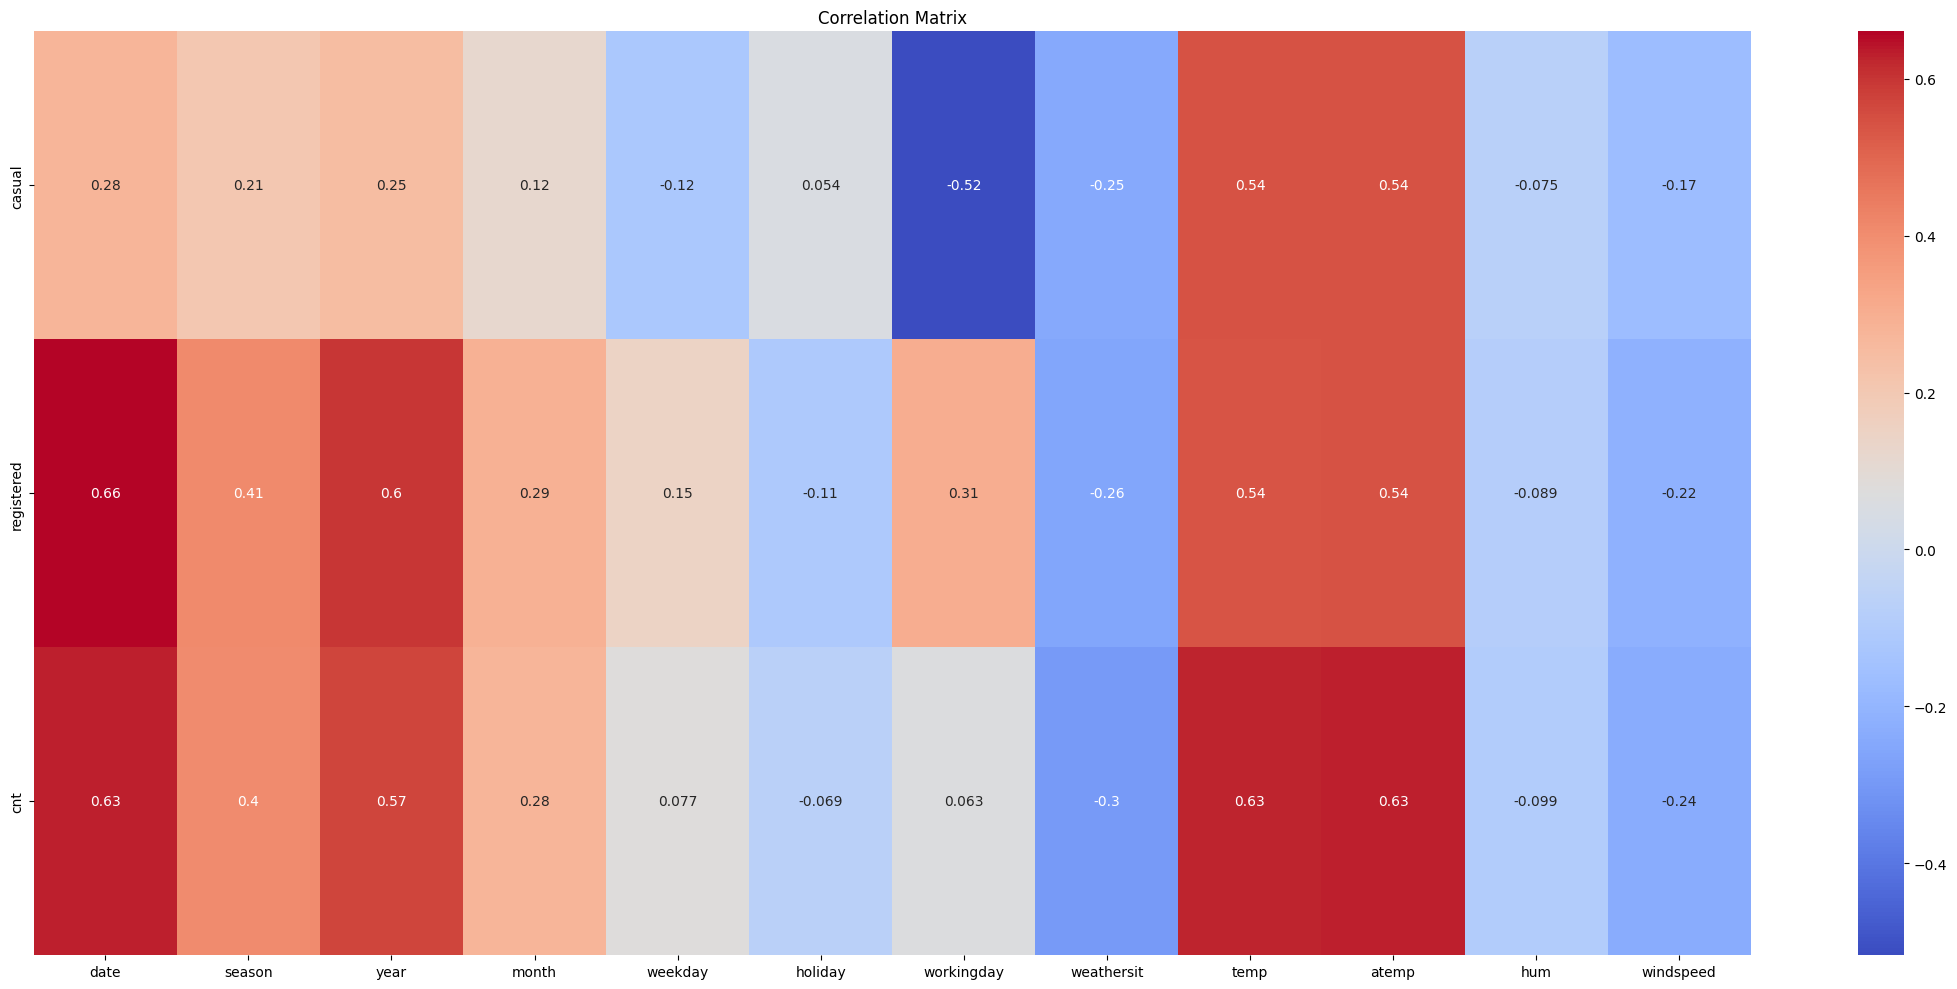

In [30]:
# Correlation matrix for numeric features
plt.figure(figsize=(22, 10))

corr = bike_tmp_num_df.corr()
sns.heatmap(corr.loc[['casual', 'registered', 'cnt'], corr.columns[:-3]], cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### Bivariate Analysis - Continuous Variables Observations:

Variables `year` and `date` are continuous, but they are not suitable as features for model, as they will continue to increase over time regardless of any external factors. Therefore, we will exclude these columns in future analyses. 

Additionally, `temp` and `atemp` represent similar information, with `atemp` indicating the "feels-like" temperature, which does not provide significant additional value. As a result, we will drop one of these columns to avoid redundancy.

Furthermore, the `workingday` variable is derived from the combination of `weekday` and `holiday`, making it redundant. Therefore, we will drop the `weekday`, and `holiday` columns to simplify model.

**Casual**:
The `casual` variable shows a moderate positive correlation with `season`, and `temp`, indicating that casual bike rentals are influenced by seasonal changes and temperature, but weakly by working days.

**Registered**:
The `registered` variable has strong positive correlations with `season`,  and `temp`, suggesting that registered users are more likely to rent bikes during specific seasons and in favorable weather conditions, with minimal influence from working day.

Moving forward we will maintain one Dataframe and drop `cacual` users and `registered` users. as they get represent target variable.

In [206]:
df = bike_df.copy(deep=True)
df = df.drop(columns=['year', 'date', 'registered', 'casual'])

## Model Preparation

In [207]:
df.head()

season    month    weekday holiday workingday           weathersit  temp  \
0  Spring  January     Monday   False      False        Mist + Cloudy 14.11   
1  Spring  January    Tuesday   False      False        Mist + Cloudy 14.90   
2  Spring  January  Wednesday   False       True  Clear or Few Clouds  8.05   
3  Spring  January   Thursday   False       True  Clear or Few Clouds  8.20   
4  Spring  January     Friday   False       True  Clear or Few Clouds  9.31   

   atemp   hum  windspeed   cnt  
0  18.18 80.58      10.75   985  
1  17.69 69.61      16.65   801  
2   9.47 43.73      16.64  1349  
3  10.61 59.04      10.74  1562  
4  11.46 43.70      12.52  1600

In [208]:
#Create Dummies for the categorical Variables
categorical_vars = ['season', 'month', 'weekday', 'weathersit']
print("List of Categorical Variables are :", categorical_vars)

print(" ")


df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
df = df.replace({True: 1, False: 0})


List of Categorical Variables are : ['season', 'month', 'weekday', 'weathersit']
 


C:\Users\outsi\AppData\Local\Temp\ipykernel_11432\4083238163.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})
C:\Users\outsi\AppData\Local\Temp\ipykernel_11432\4083238163.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace({True: 1, False: 0})


In [209]:
#Lets check the shape of dataframe
print("Shape of bike casual users Dataframe now is :",df.shape)

# Let's have a look at cars dataframe
df.head()

Shape of bike casual users Dataframe now is : (730, 29)


holiday workingday  temp  atemp   hum  windspeed   cnt  season_Spring  \
0       0          0 14.11  18.18 80.58      10.75   985              1   
1       0          0 14.90  17.69 69.61      16.65   801              1   
2       0          1  8.05   9.47 43.73      16.64  1349              1   
3       0          1  8.20  10.61 59.04      10.74  1562              1   
4       0          1  9.31  11.46 43.70      12.52  1600              1   

   season_Summer  season_Winter  month_August  month_December  month_February  \
0              0              0             0               0               0   
1              0              0             0               0               0   
2              0              0             0               0               0   
3              0              0             0               0               0   
4              0              0             0               0               0   

   month_January  month_July  month_June  month_March  month_May  \
0              1           0           0            0          0   
1              1           0           0            0          0   
2              1           0           0            0          0   
3              1           0           0            0          0   
4              1           0           0            0          0   

   month_November  month_October  month_September  weekday_Monday  \
0               0              0                0               1   
1               0              0                0               0   
2               0              0                0               0   
3               0              0                0               0   
4               0              0                0               0   

   weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
0                 0               0                 0                0   
1                 0               0                 0                1   
2                 0               0                 0                0   
3                 0               0                 1                0   
4                 0               0                 0                0   

   weekday_Wednesday  weathersit_Light Snow or Rain  weathersit_Mist + Cloudy  
0                  0                              0                         1  
1                  0                              0                         1  
2                  1                              0                         0  
3                  0                              0                         0  
4                  0                              0                         0

## Data Splitting Training and Testing Set

In [210]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [211]:
# As our data having outliers we are moving with min max scaler
# Using MinMaxScaler to scale all the numeric variables in the same scale between 0 and 1.
scaler = MinMaxScaler()

In [212]:
# Applying scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'windspeed', 'hum', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
display(df_train.head())
#Describe the train dataset to check the minmax range should be between 0 and 1
display(df_train.describe())

holiday workingday  temp  atemp  hum  windspeed  cnt  season_Spring  \
653       0          1  0.51   0.50 0.58       0.30 0.86              0   
576       0          1  0.82   0.77 0.73       0.26 0.83              0   
426       0          0  0.44   0.44 0.64       0.26 0.47              1   
728       0          0  0.25   0.20 0.50       0.66 0.20              1   
482       0          0  0.40   0.39 0.50       0.19 0.48              0   

     season_Summer  season_Winter  month_August  month_December  \
653              0              1             0               0   
576              0              0             0               0   
426              0              0             0               0   
728              0              0             0               1   
482              1              0             0               0   

     month_February  month_January  month_July  month_June  month_March  \
653               0              0           0           0            0   
576               0              0           1           0            0   
426               0              0           0           0            1   
728               0              0           0           0            0   
482               0              0           0           0            0   

     month_May  month_November  month_October  month_September  \
653          0               0              1                0   
576          0               0              0                0   
426          0               0              0                0   
728          0               0              0                0   
482          0               0              0                0   

     weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
653               0                 0               0                 0   
576               0                 0               0                 0   
426               0                 0               1                 0   
728               1                 0               0                 0   
482               0                 0               1                 0   

     weekday_Tuesday  weekday_Wednesday  weathersit_Light Snow or Rain  \
653                0                  1                              0   
576                0                  1                              0   
426                0                  0                              0   
728                0                  0                              0   
482                0                  0                              0   

     weathersit_Mist + Cloudy  
653                         0  
576                         0  
426                         1  
728                         0  
482                         1

temp  atemp    hum  windspeed    cnt  season_Spring  season_Summer  \
count 510.00 510.00 510.00     510.00 510.00         510.00         510.00   
mean    0.54   0.51   0.65       0.32   0.51           0.24           0.25   
std     0.23   0.21   0.15       0.17   0.22           0.43           0.43   
min     0.00   0.00   0.00       0.00   0.00           0.00           0.00   
25%     0.34   0.33   0.54       0.20   0.36           0.00           0.00   
50%     0.54   0.53   0.65       0.30   0.52           0.00           0.00   
75%     0.74   0.69   0.75       0.41   0.68           0.00           0.00   
max     1.00   1.00   1.00       1.00   1.00           1.00           1.00   

       season_Winter  month_August  month_December  month_February  \
count         510.00        510.00          510.00          510.00   
mean            0.25          0.10            0.08            0.07   
std             0.43          0.29            0.28            0.25   
min             0.00          0.00            0.00            0.00   
25%             0.00          0.00            0.00            0.00   
50%             0.00          0.00            0.00            0.00   
75%             0.00          0.00            0.00            0.00   
max             1.00          1.00            1.00            1.00   

       month_January  month_July  month_June  month_March  month_May  \
count         510.00      510.00      510.00       510.00     510.00   
mean            0.09        0.08        0.07         0.10       0.08   
std             0.28        0.27        0.26         0.30       0.28   
min             0.00        0.00        0.00         0.00       0.00   
25%             0.00        0.00        0.00         0.00       0.00   
50%             0.00        0.00        0.00         0.00       0.00   
75%             0.00        0.00        0.00         0.00       0.00   
max             1.00        1.00        1.00         1.00       1.00   

       month_November  month_October  month_September  weekday_Monday  \
count          510.00         510.00           510.00          510.00   
mean             0.09           0.09             0.08            0.15   
std              0.28           0.28             0.27            0.36   
min              0.00           0.00             0.00            0.00   
25%              0.00           0.00             0.00            0.00   
50%              0.00           0.00             0.00            0.00   
75%              0.00           0.00             0.00            0.00   
max              1.00           1.00             1.00            1.00   

       weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
count            510.00          510.00            510.00           510.00   
mean               0.13            0.14              0.14             0.15   
std                0.34            0.34              0.35             0.36   
min                0.00            0.00              0.00             0.00   
25%                0.00            0.00              0.00             0.00   
50%                0.00            0.00              0.00             0.00   
75%                0.00            0.00              0.00             0.00   
max                1.00            1.00              1.00             1.00   

       weekday_Wednesday  weathersit_Light Snow or Rain  \
count             510.00                         510.00   
mean                0.14                           0.03   
std                 0.34                           0.17   
min                 0.00                           0.00   
25%                 0.00                           0.00   
50%                 0.00                           0.00   
75%                 0.00                           0.00   
max                 1.00                           1.00   

       weathersit_Mist + Cloudy  
count                    510.00  
mean                       0.34  
std                        0.4

In [213]:
# Let's seperate the dependent variable from the train dataset
y_train = df_train.pop('cnt')
X_train = df_train

## Model Building

Let us follow a mixed approach.

- Initially, we shall use the LinearRegression function from SciKit Learn for its compatibility with RFE.
- Then we will be using the statsmodels for statistics analysis of the model

In [214]:
# Creating lm object
lm = LinearRegression()
lm.fit(X_train, y_train)

# Running RFE and selecting  best features
rfe = RFE(estimator=lm, n_features_to_select=61) 
rfe = rfe.fit(X_train, y_train)

c:\Users\outsi\miniforge3\envs\aiml\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=61 > n_features=28. There will be no feature selection and all features will be kept.
  warnings.warn(


In [215]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', np.True_, np.int64(1)),
 ('workingday', np.True_, np.int64(1)),
 ('temp', np.True_, np.int64(1)),
 ('atemp', np.True_, np.int64(1)),
 ('hum', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('season_Spring', np.True_, np.int64(1)),
 ('season_Summer', np.True_, np.int64(1)),
 ('season_Winter', np.True_, np.int64(1)),
 ('month_August', np.True_, np.int64(1)),
 ('month_December', np.True_, np.int64(1)),
 ('month_February', np.True_, np.int64(1)),
 ('month_January', np.True_, np.int64(1)),
 ('month_July', np.True_, np.int64(1)),
 ('month_June', np.True_, np.int64(1)),
 ('month_March', np.True_, np.int64(1)),
 ('month_May', np.True_, np.int64(1)),
 ('month_November', np.True_, np.int64(1)),
 ('month_October', np.True_, np.int64(1)),
 ('month_September', np.True_, np.int64(1)),
 ('weekday_Monday', np.True_, np.int64(1)),
 ('weekday_Saturday', np.True_, np.int64(1)),
 ('weekday_Sunday', np.True_, np.int64(1)),
 ('weekday_Thursday', np.True_, np.int64(1)),
 ('weekd

In [216]:
# Top 15 columns which looks effective to train the model after performing RFE
cols = X_train.columns[rfe.support_]
cols

Index(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Light Snow or Rain',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [217]:
len(cols)

28

In [218]:
# Define a function for populate the statsmodel summary
def fitLR(X_train_rfe, y_train):
    # Adding a constant variable
    # import statsmodels.api as sm
    X_train_rfe = sm.add_constant(X_train_rfe, has_constant='add')
    
    X_train_rfe = X_train_rfe.apply(pd.to_numeric, errors='coerce')
    y_train = pd.to_numeric(y_train, errors='coerce')

    # Running the linear model
    lm = sm.OLS(y_train, X_train_rfe.apply(pd.to_numeric, errors='coerce')).fit()
    
    # Print Summary of linear model
    print(lm.summary())
    
    return lm

In [219]:
# Function to get VIF
def Cal_VIF(X_train):
    
    vif = pd.DataFrame()
    
    X = X_train
    
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    
    vif = vif.sort_values(by = "VIF", ascending = False)
    
    return(vif)

In [220]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[cols]

In [221]:
X_train_rfe.head()

holiday workingday  temp  atemp  hum  windspeed  season_Spring  \
653       0          1  0.51   0.50 0.58       0.30              0   
576       0          1  0.82   0.77 0.73       0.26              0   
426       0          0  0.44   0.44 0.64       0.26              1   
728       0          0  0.25   0.20 0.50       0.66              1   
482       0          0  0.40   0.39 0.50       0.19              0   

     season_Summer  season_Winter  month_August  month_December  \
653              0              1             0               0   
576              0              0             0               0   
426              0              0             0               0   
728              0              0             0               1   
482              1              0             0               0   

     month_February  month_January  month_July  month_June  month_March  \
653               0              0           0           0            0   
576               0              0           1           0            0   
426               0              0           0           0            1   
728               0              0           0           0            0   
482               0              0           0           0            0   

     month_May  month_November  month_October  month_September  \
653          0               0              1                0   
576          0               0              0                0   
426          0               0              0                0   
728          0               0              0                0   
482          0               0              0                0   

     weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
653               0                 0               0                 0   
576               0                 0               0                 0   
426               0                 0               1                 0   
728               1                 0               0                 0   
482               0                 0               1                 0   

     weekday_Tuesday  weekday_Wednesday  weathersit_Light Snow or Rain  \
653                0                  1                              0   
576                0                  1                              0   
426                0                  0                              0   
728                0                  0                              0   
482                0                  0                              0   

     weathersit_Mist + Cloudy  
653                         0  
576                         0  
426                         1  
728                         0  
482                         1

In [222]:
# Call fitLR Function to get OLS Regression Results
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     25.71
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           7.68e-78
Time:                        04:08:32   Log-Likelihood:                 271.82
No. Observations:                 510   AIC:                            -485.6
Df Residuals:                     481   BIC:                            -362.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

P value of `month_March` is greater than 0.05, so lets remove this column

In [223]:
X_train_rfe.drop(columns = ['month_March'], axis = 1, inplace = True)

In [224]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features    VIF
2                            temp 433.68
3                           atemp 382.31
4                             hum  36.07
8                   season_Winter  10.79
6                   season_Spring   8.68
1                      workingday   8.41
7                   season_Summer   7.37
9                    month_August   5.85
5                       windspeed   5.47
13                     month_July   5.22
17                  month_October   5.11
16                 month_November   4.89
18                month_September   3.97
19                 weekday_Monday   3.70
10                 month_December   3.39
14                     month_June   2.76
12                  month_January   2.66
23                weekday_Tuesday   2.48
26       weathersit_Mist + Cloudy   2.37
21                 weekday_Sunday   2.16
15                      month_May   2.10
11                 month_February   2.07
22               weekday_Thursday   1.98
24              weekday_Wednesday   1.94
20               weekday_Saturday   1.86
0                         holiday   1.35
25  weathersit_Light Snow or Rain   1.33

In [225]:
X_train_rfe.drop(columns = ['atemp'], axis = 1, inplace = True)

In [226]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     27.79
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.91e-79
Time:                        04:08:36   Log-Likelihood:                 271.76
No. Observations:                 510   AIC:                            -489.5
Df Residuals:                     483   BIC:                            -375.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [227]:
X_train_rfe.drop(columns = ['weekday_Tuesday'], axis = 1, inplace = True)

In [228]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
2                            temp 35.77
3                             hum 35.17
7                   season_Winter 10.53
5                   season_Spring  8.33
6                   season_Summer  6.98
1                      workingday  6.96
8                    month_August  5.67
16                  month_October  5.10
4                       windspeed  5.08
12                     month_July  5.08
15                 month_November  4.88
17                month_September  3.90
9                  month_December  3.38
13                     month_June  2.71
11                  month_January  2.64
24       weathersit_Mist + Cloudy  2.36
18                 weekday_Monday  2.30
14                      month_May  2.08
10                 month_February  2.06
21               weekday_Thursday  1.64
22              weekday_Wednesday  1.61
19               weekday_Saturday  1.55
20                 weekday_Sunday  1.49
0                         holiday  1.32
23  weathersit_Light Snow or Rain  1.30

In [229]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     28.96
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           5.37e-80
Time:                        04:08:41   Log-Likelihood:                 271.75
No. Observations:                 510   AIC:                            -491.5
Df Residuals:                     484   BIC:                            -381.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [230]:
X_train_rfe.drop(columns = ['weekday_Saturday'], axis = 1, inplace = True)

In [231]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
2                            temp 35.69
3                             hum 35.05
7                   season_Winter 10.52
5                   season_Spring  8.28
6                   season_Summer  6.93
1                      workingday  6.44
8                    month_August  5.65
16                  month_October  5.09
12                     month_July  5.07
4                       windspeed  5.07
15                 month_November  4.87
17                month_September  3.89
9                  month_December  3.37
13                     month_June  2.71
11                  month_January  2.64
23       weathersit_Mist + Cloudy  2.36
18                 weekday_Monday  2.28
14                      month_May  2.08
10                 month_February  2.06
20               weekday_Thursday  1.43
21              weekday_Wednesday  1.42
19                 weekday_Sunday  1.40
0                         holiday  1.31
22  weathersit_Light Snow or Rain  1.30

In [232]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     30.23
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           9.80e-81
Time:                        04:09:13   Log-Likelihood:                 271.74
No. Observations:                 510   AIC:                            -493.5
Df Residuals:                     485   BIC:                            -387.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [233]:
X_train_rfe.drop(columns = ['weekday_Wednesday'], axis = 1, inplace = True)

In [234]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
2                            temp 35.68
3                             hum 35.04
7                   season_Winter 10.50
5                   season_Spring  8.28
6                   season_Summer  6.92
1                      workingday  6.17
8                    month_August  5.64
16                  month_October  5.09
4                       windspeed  5.07
12                     month_July  5.07
15                 month_November  4.87
17                month_September  3.89
9                  month_December  3.37
13                     month_June  2.71
11                  month_January  2.63
22       weathersit_Mist + Cloudy  2.36
18                 weekday_Monday  2.28
14                      month_May  2.08
10                 month_February  2.06
19                 weekday_Sunday  1.36
20               weekday_Thursday  1.33
21  weathersit_Light Snow or Rain  1.30
0                         holiday  1.25

In [235]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     31.60
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           1.74e-81
Time:                        04:09:48   Log-Likelihood:                 271.72
No. Observations:                 510   AIC:                            -495.4
Df Residuals:                     486   BIC:                            -393.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [236]:
X_train_rfe.drop(columns = ['weekday_Monday'], axis = 1, inplace = True)

In [237]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
2                            temp 35.52
3                             hum 34.88
7                   season_Winter 10.45
5                   season_Spring  7.98
6                   season_Summer  6.62
8                    month_August  5.52
16                  month_October  5.05
4                       windspeed  5.02
12                     month_July  4.98
15                 month_November  4.82
17                month_September  3.82
1                      workingday  3.53
9                  month_December  3.32
13                     month_June  2.69
11                  month_January  2.62
21       weathersit_Mist + Cloudy  2.36
14                      month_May  2.08
10                 month_February  2.06
19               weekday_Thursday  1.33
20  weathersit_Light Snow or Rain  1.30
18                 weekday_Sunday  1.21
0                         holiday  1.14

In [238]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     33.10
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           3.14e-82
Time:                        04:10:19   Log-Likelihood:                 271.67
No. Observations:                 510   AIC:                            -497.3
Df Residuals:                     487   BIC:                            -399.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [239]:
X_train_rfe.drop(columns = ['month_August'], axis = 1, inplace = True)

In [240]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 33.92
2                            temp 21.90
7                   season_Winter  9.65
5                   season_Spring  5.50
4                       windspeed  4.99
14                 month_November  4.55
15                  month_October  4.44
6                   season_Summer  3.72
1                      workingday  3.53
8                  month_December  3.24
10                  month_January  2.56
20       weathersit_Mist + Cloudy  2.36
9                  month_February  2.05
13                      month_May  1.78
11                     month_July  1.76
16                month_September  1.68
12                     month_June  1.63
18               weekday_Thursday  1.33
19  weathersit_Light Snow or Rain  1.30
17                 weekday_Sunday  1.21
0                         holiday  1.14

In [241]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     34.72
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           5.80e-83
Time:                        04:10:49   Log-Likelihood:                 271.56
No. Observations:                 510   AIC:                            -499.1
Df Residuals:                     488   BIC:                            -406.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [242]:
X_train_rfe.drop(columns = ['season_Spring'], axis = 1, inplace = True)

In [243]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 28.19
2                            temp 19.55
6                   season_Winter  8.03
13                 month_November  4.53
14                  month_October  4.39
4                       windspeed  4.23
1                      workingday  3.49
7                  month_December  3.15
5                   season_Summer  3.04
19       weathersit_Mist + Cloudy  2.26
9                   month_January  2.06
12                      month_May  1.78
10                     month_July  1.73
15                month_September  1.64
8                  month_February  1.64
11                     month_June  1.63
17               weekday_Thursday  1.33
18  weathersit_Light Snow or Rain  1.26
16                 weekday_Sunday  1.21
0                         holiday  1.13

In [244]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     36.52
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           9.81e-84
Time:                        04:11:17   Log-Likelihood:                 271.52
No. Observations:                 510   AIC:                            -501.0
Df Residuals:                     489   BIC:                            -412.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [245]:
X_train_rfe.drop(columns = ['month_October'], axis = 1, inplace = True)

In [246]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 26.91
2                            temp 19.32
4                       windspeed  4.15
1                      workingday  3.49
6                   season_Winter  2.95
5                   season_Summer  2.89
18       weathersit_Mist + Cloudy  2.25
9                   month_January  1.96
13                 month_November  1.87
12                      month_May  1.78
10                     month_July  1.71
7                  month_December  1.67
11                     month_June  1.62
8                  month_February  1.57
14                month_September  1.38
16               weekday_Thursday  1.33
17  weathersit_Light Snow or Rain  1.26
15                 weekday_Sunday  1.21
0                         holiday  1.13

In [247]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     38.48
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           1.79e-84
Time:                        04:11:47   Log-Likelihood:                 271.37
No. Observations:                 510   AIC:                            -502.7
Df Residuals:                     490   BIC:                            -418.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [248]:
X_train_rfe.drop(columns = ['month_February'], axis = 1, inplace = True)

In [249]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 22.14
2                            temp 16.16
4                       windspeed  3.80
1                      workingday  3.46
6                   season_Winter  2.76
5                   season_Summer  2.58
17       weathersit_Mist + Cloudy  2.19
12                 month_November  1.84
11                      month_May  1.77
9                      month_July  1.71
8                   month_January  1.63
10                     month_June  1.61
7                  month_December  1.57
13                month_September  1.36
15               weekday_Thursday  1.32
16  weathersit_Light Snow or Rain  1.23
14                 weekday_Sunday  1.21
0                         holiday  1.11

In [250]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     40.68
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           3.07e-85
Time:                        04:13:56   Log-Likelihood:                 271.26
No. Observations:                 510   AIC:                            -504.5
Df Residuals:                     491   BIC:                            -424.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [251]:
X_train_rfe.drop(columns = ['month_January'], axis = 1, inplace = True)

In [252]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 16.99
2                            temp 12.84
4                       windspeed  3.74
1                      workingday  3.43
6                   season_Winter  2.64
5                   season_Summer  2.42
16       weathersit_Mist + Cloudy  2.15
11                 month_November  1.81
10                      month_May  1.77
8                      month_July  1.70
9                      month_June  1.58
7                  month_December  1.49
12                month_September  1.36
14               weekday_Thursday  1.32
13                 weekday_Sunday  1.21
15  weathersit_Light Snow or Rain  1.19
0                         holiday  1.11

In [253]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     43.14
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           4.85e-86
Time:                        04:14:19   Log-Likelihood:                 271.21
No. Observations:                 510   AIC:                            -506.4
Df Residuals:                     492   BIC:                            -430.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [254]:
X_train_rfe.drop(columns = ['weekday_Thursday'], axis = 1, inplace = True)

In [255]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     45.85
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           9.07e-87
Time:                        04:14:38   Log-Likelihood:                 270.94
No. Observations:                 510   AIC:                            -507.9
Df Residuals:                     493   BIC:                            -435.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [256]:
X_train_rfe.drop(columns = ['month_December'], axis = 1, inplace = True)

In [257]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 16.05
2                            temp 12.16
4                       windspeed  3.73
1                      workingday  3.17
5                   season_Summer  2.40
6                   season_Winter  2.28
14       weathersit_Mist + Cloudy  2.12
9                       month_May  1.77
7                      month_July  1.69
10                 month_November  1.59
8                      month_June  1.57
11                month_September  1.35
12                 weekday_Sunday  1.18
13  weathersit_Light Snow or Rain  1.16
0                         holiday  1.11

In [258]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     48.90
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           1.74e-87
Time:                        04:14:57   Log-Likelihood:                 270.61
No. Observations:                 510   AIC:                            -509.2
Df Residuals:                     494   BIC:                            -441.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [259]:
X_train_rfe.drop(columns = ['month_November'], axis = 1, inplace = True)

In [260]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 16.05
2                            temp 12.14
4                       windspeed  3.71
1                      workingday  3.17
5                   season_Summer  2.40
13       weathersit_Mist + Cloudy  2.12
9                       month_May  1.77
6                   season_Winter  1.71
7                      month_July  1.69
8                      month_June  1.57
10                month_September  1.34
11                 weekday_Sunday  1.18
12  weathersit_Light Snow or Rain  1.16
0                         holiday  1.09

In [261]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     52.42
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.89e-88
Time:                        04:15:16   Log-Likelihood:                 270.39
No. Observations:                 510   AIC:                            -510.8
Df Residuals:                     495   BIC:                            -447.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [262]:
X_train_rfe.drop(columns = ['month_May'], axis = 1, inplace = True)

In [263]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 16.05
2                            temp 11.77
4                       windspeed  3.59
1                      workingday  3.17
12       weathersit_Mist + Cloudy  2.12
5                   season_Summer  1.78
6                   season_Winter  1.71
7                      month_July  1.66
8                      month_June  1.40
9                 month_September  1.33
10                 weekday_Sunday  1.18
11  weathersit_Light Snow or Rain  1.16
0                         holiday  1.09

In [264]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     56.37
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           6.31e-89
Time:                        04:15:40   Log-Likelihood:                 269.85
No. Observations:                 510   AIC:                            -511.7
Df Residuals:                     496   BIC:                            -452.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [265]:
X_train_rfe.drop(columns = ['weekday_Sunday'], axis = 1, inplace = True)

In [266]:
# Call Cal_VIF Function to calculate VIF
vif = Cal_VIF(X_train_rfe)

vif

Features   VIF
3                             hum 15.99
2                            temp 11.75
4                       windspeed  3.56
1                      workingday  3.13
11       weathersit_Mist + Cloudy  2.11
5                   season_Summer  1.78
6                   season_Winter  1.71
7                      month_July  1.66
8                      month_June  1.40
9                 month_September  1.33
10  weathersit_Light Snow or Rain  1.16
0                         holiday  1.09

In [267]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     60.77
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.14e-89
Time:                        04:15:56   Log-Likelihood:                 268.81
No. Observations:                 510   AIC:                            -511.6
Df Residuals:                     497   BIC:                            -456.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [268]:
X_train_rfe.drop(columns = ['workingday'], axis = 1, inplace = True)

In [269]:
# Call fitLRFunction to get stats
lm = fitLR(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     65.97
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           7.15e-90
Time:                        04:16:16   Log-Likelihood:                 267.75
No. Observations:                 510   AIC:                            -511.5
Df Residuals:                     498   BIC:                            -460.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [270]:
# Adding a constant variable
X_train_lm = sm.add_constant(X_train_rfe)

# Running the linear model
lm = sm.OLS(y_train, X_train_lm).fit()
    
# Print Summary of linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     65.97
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           7.15e-90
Time:                        04:16:57   Log-Likelihood:                 267.75
No. Observations:                 510   AIC:                            -511.5
Df Residuals:                     498   BIC:                            -460.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

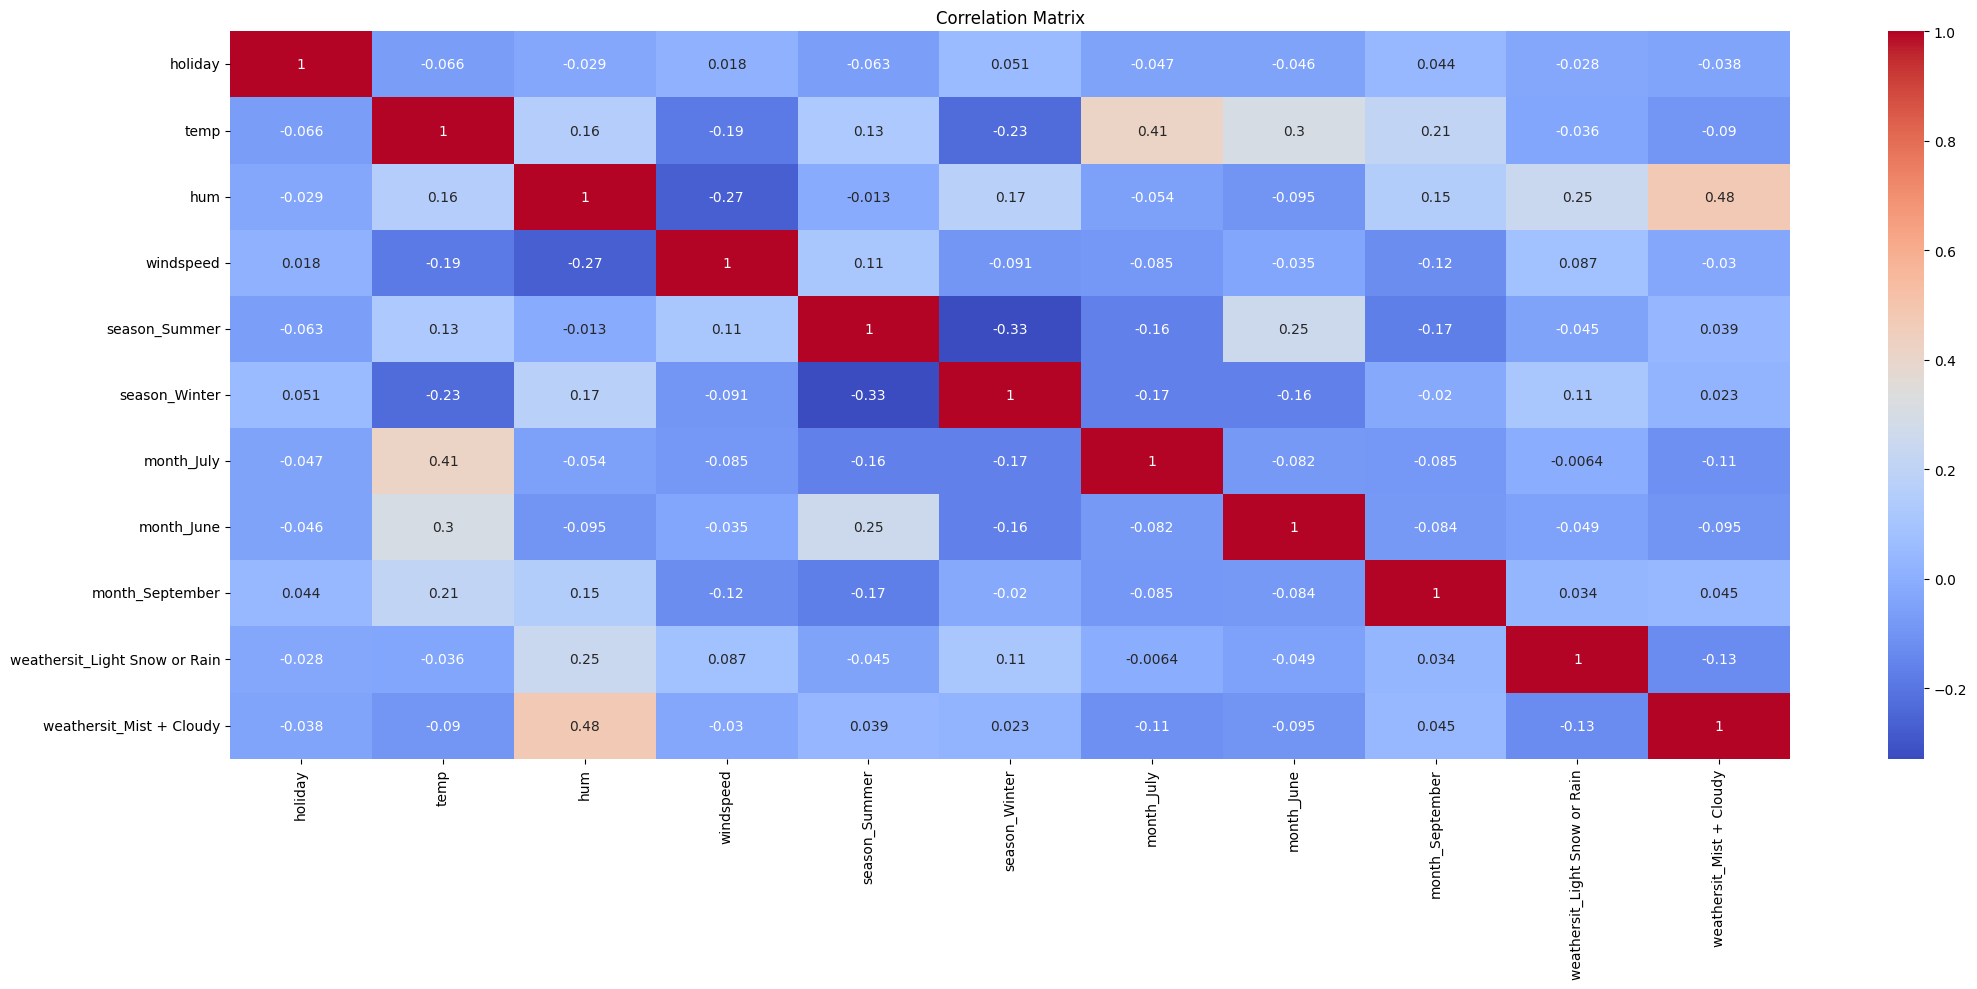

In [271]:
# Correlation matrix for numeric features
plt.figure(figsize=(22, 10))

corr = bike_tmp_num_df.corr()
sns.heatmap(X_train_rfe.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

We will conclude with these variables as the final model predictor variables.

In [272]:
y_train_price = lm.predict(X_train_lm)

<Axes: xlabel='cnt'>

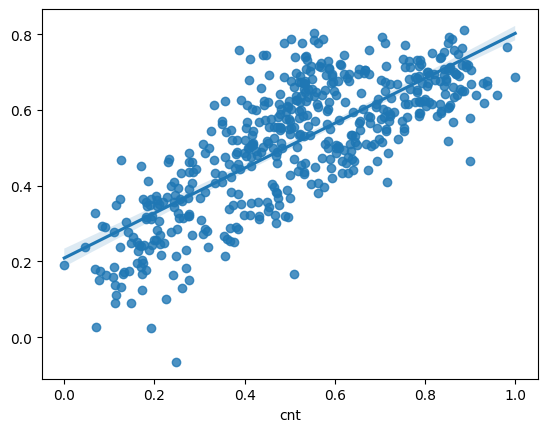

In [273]:
# Final Linear regression plot on train dataset
sns.regplot(x=y_train, y=y_train_price)

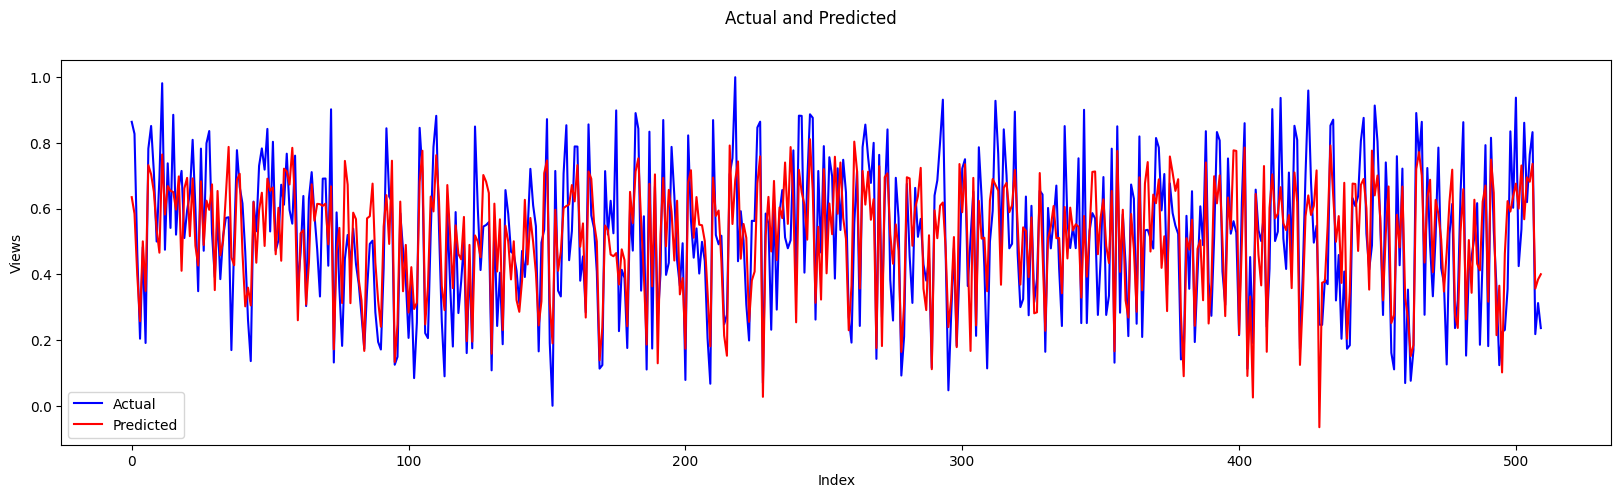

In [274]:
# Actual vs Predicted
indices = range(len(y_train))  # Dynamically calculate range based on data length
fig = plt.figure(figsize=(20, 5))
plt.plot(indices, y_train, color="blue", linewidth=1.5, linestyle="-", label="Actual")
plt.plot(indices, y_train_price, color="red", linewidth=1.5, linestyle="-", label="Predicted")

# Add plot details
fig.suptitle('Actual and Predicted')  # Plot heading
plt.xlabel('Index')                   # X-label
plt.ylabel('Views')                   # Y-label
plt.legend()                            # Add legend
plt.show()

<Figure size 1000x1000 with 0 Axes>

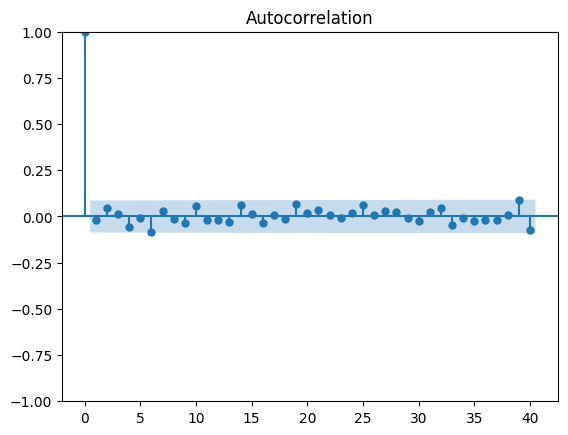

In [275]:
# TSA Plot on Train data
fig = plt.figure(figsize=(10,10))
sm.graphics.tsa.plot_acf(y_train-y_train_price, lags=40)
plt.show()

## Residual Analysis of the Train Data

C:\Users\outsi\AppData\Local\Temp\ipykernel_11432\2978033036.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_train_price), bins = 20)


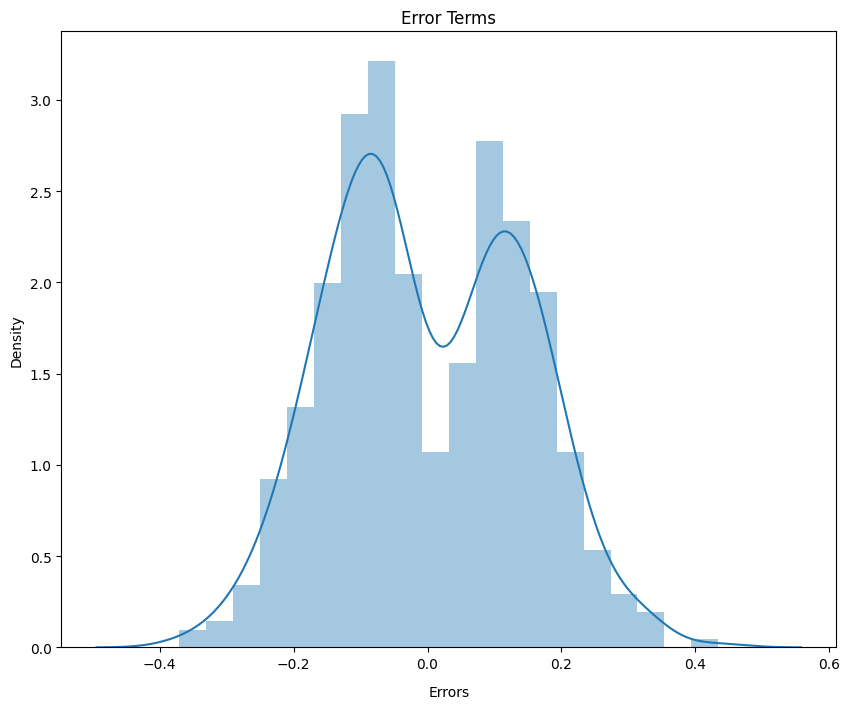

In [276]:
# Distribution Plot
plt.figure(figsize = (10, 8))

sns.distplot((y_train - y_train_price), bins = 20)

plt.xlabel('Errors', labelpad = 10)
plt.title('Error Terms')
plt.show()

In [277]:
# Perform scaling on list of variables which are picked in train dataset
num_vars = ['temp', 'atemp', 'windspeed', 'hum', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
display(df_train.head())
#Describe the train dataset to check the minmax range should be between 0 and 1
display(df_train.describe())

holiday workingday  temp  atemp  hum  windspeed  season_Spring  \
653       0          1  0.51   0.50 0.58       0.30              0   
576       0          1  0.82   0.77 0.73       0.26              0   
426       0          0  0.44   0.44 0.64       0.26              1   
728       0          0  0.25   0.20 0.50       0.66              1   
482       0          0  0.40   0.39 0.50       0.19              0   

     season_Summer  season_Winter  month_August  month_December  \
653              0              1             0               0   
576              0              0             0               0   
426              0              0             0               0   
728              0              0             0               1   
482              1              0             0               0   

     month_February  month_January  month_July  month_June  month_March  \
653               0              0           0           0            0   
576               0              0           1           0            0   
426               0              0           0           0            1   
728               0              0           0           0            0   
482               0              0           0           0            0   

     month_May  month_November  month_October  month_September  \
653          0               0              1                0   
576          0               0              0                0   
426          0               0              0                0   
728          0               0              0                0   
482          0               0              0                0   

     weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
653               0                 0               0                 0   
576               0                 0               0                 0   
426               0                 0               1                 0   
728               1                 0               0                 0   
482               0                 0               1                 0   

     weekday_Tuesday  weekday_Wednesday  weathersit_Light Snow or Rain  \
653                0                  1                              0   
576                0                  1                              0   
426                0                  0                              0   
728                0                  0                              0   
482                0                  0                              0   

     weathersit_Mist + Cloudy  
653                         0  
576                         0  
426                         1  
728                         0  
482                         1

temp  atemp    hum  windspeed  season_Spring  season_Summer  \
count 510.00 510.00 510.00     510.00         510.00         510.00   
mean    0.54   0.51   0.65       0.32           0.24           0.25   
std     0.23   0.21   0.15       0.17           0.43           0.43   
min     0.00   0.00   0.00       0.00           0.00           0.00   
25%     0.34   0.33   0.54       0.20           0.00           0.00   
50%     0.54   0.53   0.65       0.30           0.00           0.00   
75%     0.74   0.69   0.75       0.41           0.00           0.00   
max     1.00   1.00   1.00       1.00           1.00           1.00   

       season_Winter  month_August  month_December  month_February  \
count         510.00        510.00          510.00          510.00   
mean            0.25          0.10            0.08            0.07   
std             0.43          0.29            0.28            0.25   
min             0.00          0.00            0.00            0.00   
25%             0.00          0.00            0.00            0.00   
50%             0.00          0.00            0.00            0.00   
75%             0.00          0.00            0.00            0.00   
max             1.00          1.00            1.00            1.00   

       month_January  month_July  month_June  month_March  month_May  \
count         510.00      510.00      510.00       510.00     510.00   
mean            0.09        0.08        0.07         0.10       0.08   
std             0.28        0.27        0.26         0.30       0.28   
min             0.00        0.00        0.00         0.00       0.00   
25%             0.00        0.00        0.00         0.00       0.00   
50%             0.00        0.00        0.00         0.00       0.00   
75%             0.00        0.00        0.00         0.00       0.00   
max             1.00        1.00        1.00         1.00       1.00   

       month_November  month_October  month_September  weekday_Monday  \
count          510.00         510.00           510.00          510.00   
mean             0.09           0.09             0.08            0.15   
std              0.28           0.28             0.27            0.36   
min              0.00           0.00             0.00            0.00   
25%              0.00           0.00             0.00            0.00   
50%              0.00           0.00             0.00            0.00   
75%              0.00           0.00             0.00            0.00   
max              1.00           1.00             1.00            1.00   

       weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
count            510.00          510.00            510.00           510.00   
mean               0.13            0.14              0.14             0.15   
std                0.34            0.34              0.35             0.36   
min                0.00            0.00              0.00             0.00   
25%                0.00            0.00              0.00             0.00   
50%                0.00            0.00              0.00             0.00   
75%                0.00            0.00              0.00             0.00   
max                1.00            1.00              1.00             1.00   

       weekday_Wednesday  weathersit_Light Snow or Rain  \
count             510.00                         510.00   
mean                0.14                           0.03   
std                 0.34                           0.17   
min                 0.00                           0.00   
25%                 0.00                           0.00   
50%                 0.00                           0.00   
75%                 0.00                           0.00   
max                 1.00                           1.00   

       weathersit_Mist + Cloudy  
count                    510.00  
mean                       0.34  
std                        0.48  
min                        0.00  
25%                      

In [278]:
# Seperating y_test and x_test
y_test = df_test.pop('cnt')
X_test = df_test

In [279]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_rfe.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [280]:
# Making predictions
y_pred = lm.predict(X_test_new)

C:\Users\outsi\AppData\Local\Temp\ipykernel_11432\2834104553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_pred), bins = 20)


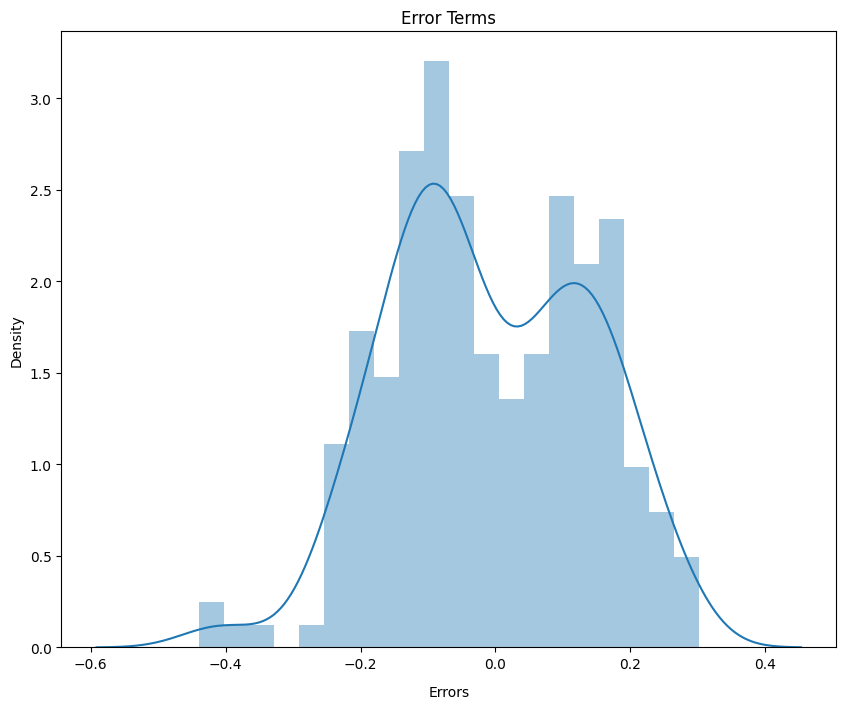

In [281]:
# Residual Plot on Test Data
# Distribution Plot
plt.figure(figsize = (10, 8))

sns.distplot((y_test - y_pred), bins = 20)

plt.xlabel('Errors', labelpad = 10)
plt.title('Error Terms')
plt.show()

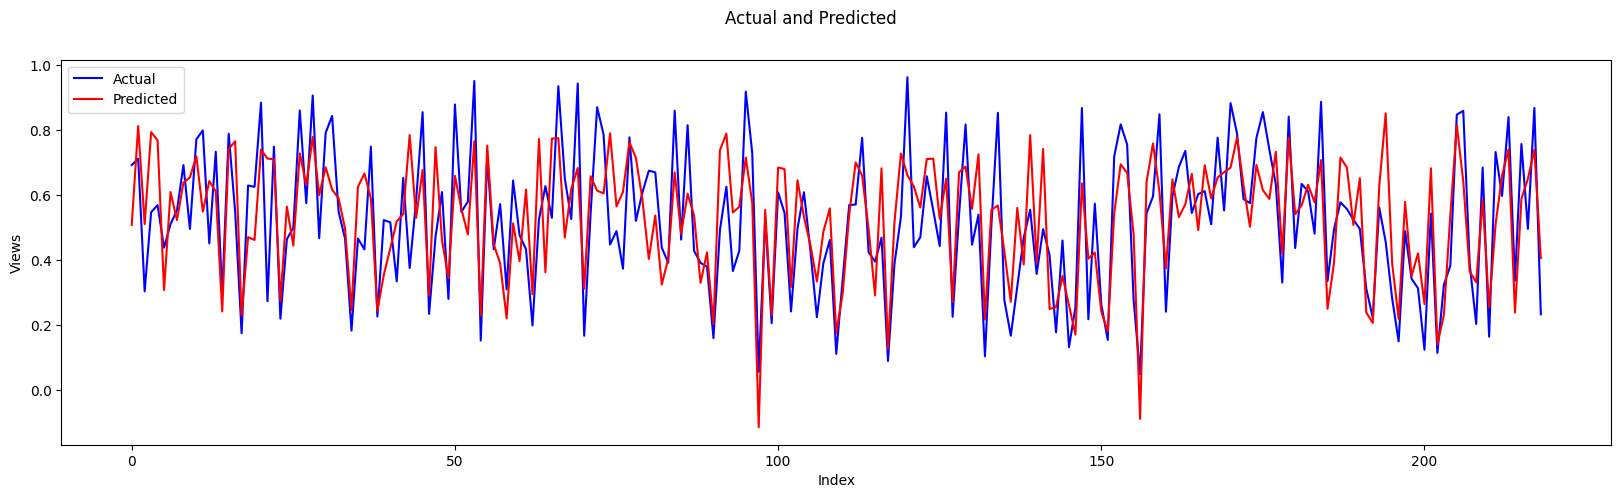

In [282]:
# Actual vs Predicted
indices = range(len(y_test))  # Dynamically calculate range based on data length
fig = plt.figure(figsize=(20, 5))
plt.plot(indices, y_test, color="blue", linewidth=1.5, linestyle="-", label="Actual")
plt.plot(indices, y_pred, color="red", linewidth=1.5, linestyle="-", label="Predicted")

# Add plot details
fig.suptitle('Actual and Predicted')  # Plot heading
plt.xlabel('Index')                   # X-label
plt.ylabel('Views')                   # Y-label
plt.legend()                            # Add legend
plt.show()

<Figure size 1000x1000 with 0 Axes>

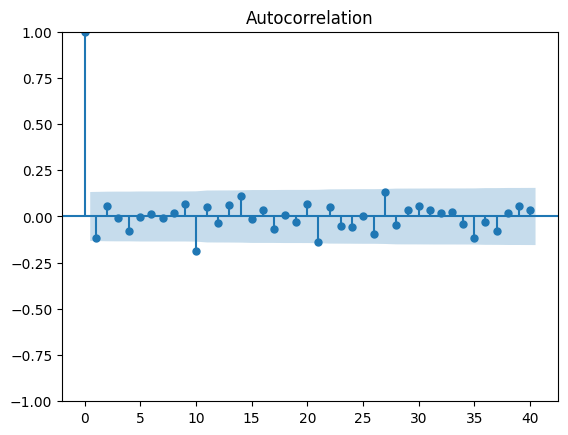

In [283]:
#TSA Pllot on Test data
fig = plt.figure(figsize=(10,10))
sm.graphics.tsa.plot_acf(y_test-y_pred, lags=40)
plt.show()

<Axes: xlabel='cnt'>

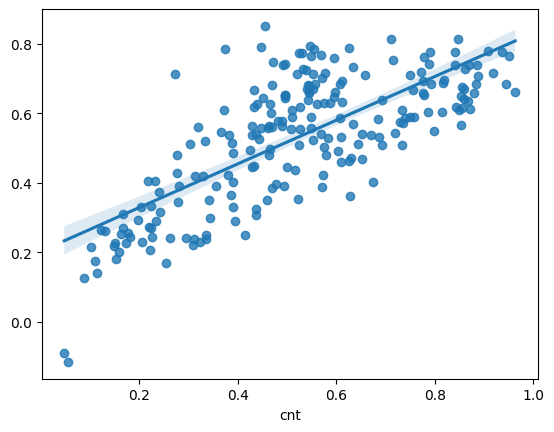

In [284]:
# Final Linear regression plot on test dataset
sns.regplot(x=y_test, y=y_pred)

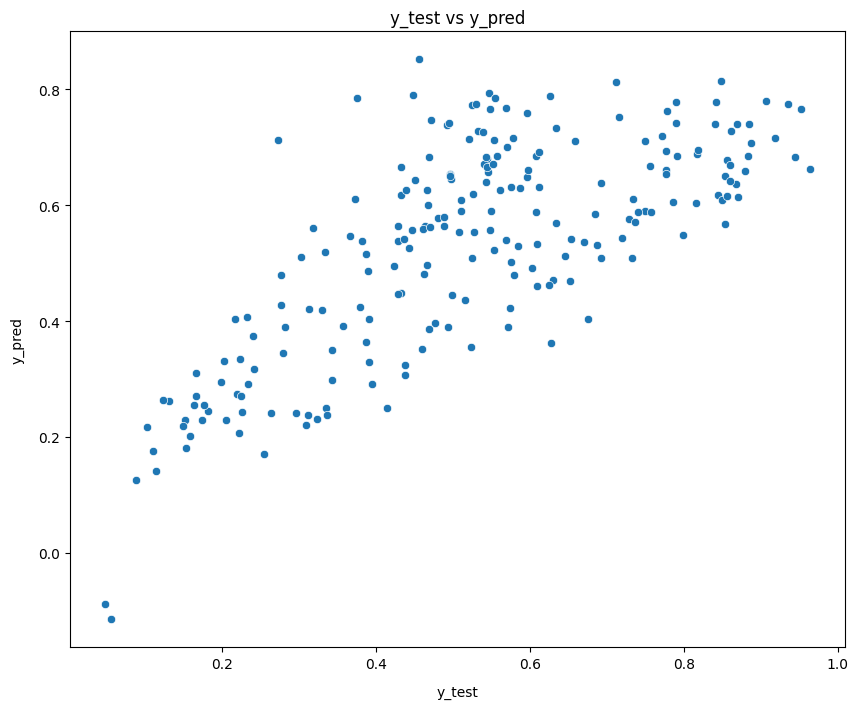

In [285]:
# Plotting y_test and y_pred to understand the spread.
plt.figure(figsize = (10, 8))

sns.scatterplot(x = y_test, y = y_pred)

plt.xlabel('y_test', labelpad = 10)
plt.ylabel('y_pred', labelpad = 10)
plt.title('y_test vs y_pred')
plt.show()

In [286]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Model RMSE:',rmse)


# Below code must be used as per assignment guidelines
from sklearn.metrics import r2_score                                                             
r2=r2_score(y_test, y_pred)                                                                     
print('Model r2_score:',r2) 

Model RMSE: 0.1487404125872768
Model r2_score: 0.534196570218769


## Final Inference
Variables which are significant in predicting the demand of bikes 

- Final predictors and their corresponding Coefficients, p values and VIF values are:

| Variable Name	                      | Coefficient Value	    | P-Value	  | VIF        |
|-------------------------------------|-------------------------|-------------|------------|
| holiday                             | -0.1082                 |  0.009      | 1.04 |
| temp                                |  0.7121                 |  0.000      | 11.61 |
| hum                                 | -0.3120                 |  0.000      | 14.97 |
| windspeed                           | -0.1997                 |  0.000      | 3.51 |
| season_Summer                       |  0.0805                 |  0.000      | 1.78 |
| season_Winter                       |  0.1409                 |  0.000      | 1.71 |
| month_July                          | -0.0873                 |  0.004      | 1.66 |
| month_June                          | -0.0590                 |  0.034      | 1.39 |
| month_September                     |  0.0785                 |  0.003      | 1.33 |
| weathersit_Light Snow or Rain       | -0.2410                 |  0.000      | 2.11 |


Equation of best fitted line is:

Y = 0.3705 
        - 0.1082 * holiday 
        + 0.7121 * temp 
        - 0.3120 * hum 
        - 0.1997 * windspeed
        + 0.0805 * season_Summer 
        + 0.1409 * season_Winter 
        + 0.0873 * month_July 
        - 0.0590 * month_June
        + 0.1268 * month_September 
        - 0.2410 * weathersit_Light Snow or Rain

**Where:**
- `Y`: Predicted value of total bike demand(dependent variable)
- Coefficients (e.g., `0.3705`, `-0.1082`, etc.) represent the impact of each feature on `Y`.
- Features:
  - `holiday`: Indicator for holidays
  - `temp`: Temperature
  - `hum`: Humidity
  - `windspeed`: Wind Speed
  - `season_Summer`: Indicator for Summer season
  - `season_Winter`: Indicator for Winter season
  - `month_July`: Indicator for July
  - `month_June`: Indicator for June
  - `month_September`: Indicator for September
  - `weathersit_Light Snow or Rain`: Indicator for light snow or rain weather situation

**Note**:
- Features such as `season_Summer`, `season_Winter`, `month_August`, etc., are likely dummy variables for categorical data.
- The model assumes all variables are in the same scale or properly normalized.


Significant Variables:
- `Holiday`: Negative impact on bike demand; demand decreases on holidays.
- `Temperature` (temp): Strong positive influence; higher temperatures increase demand.
- `Humidity` (hum): Negative impact; higher humidity reduces demand.
- `Windspeed` (windspeed): Negative impact; Higher Wind speed reduces demand.
- `Season`:
  - `Summer`: Moderate positive effect.
  - `Winter`: Stronger positive effect compared to summer.
- `Months`:
  - `July`: Slight positive impact.
  - `June`: Slight negative impact.
  - `September`: Higher positive impact.
- `Weather Situations`:
  - `Light Snow or Rain`: Strong negative impact.
